In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from scipy.stats import ttest_ind

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [2]:
matplotlib.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({'font.size': 14})
p = sns.color_palette('Paired', 8)
palette = sns.color_palette('Paired')

In [3]:
matplotlib.font_manager._rebuild()

In [4]:
#matplotlib.rcParams['font.family'] = 'Times New Roman'
from matplotlib import RcParams
latex_style_times = RcParams({'font.family': 'serif',
               'font.serif': ['Times'],
               'text.usetex': True,
               })
plt.style.use(latex_style_times)

In [5]:
pd.ExcelFile('svea_data_updated.xlsx').sheet_names # see all sheet names

['Saknade dagar', 'ALLT (inkl ny data)', 'ALLT (bara siffror, ej script)']

In [6]:
df = pd.read_excel('svea_data_updated.xlsx', 'ALLT (inkl ny data)')

In [7]:
print(f'data has {len(df.index)} rows')

data has 9973 rows


# Fix problems from adding new data (column name change etc)

In [8]:
df.head(5)

,Tillfälle,Unnamed: 1,Unnamed: 2,Unnamed: 3,Kamera,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Genomsnittligt värde per dag,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Måndata (USNO),Unnamed: 25
0,Passage no,DATE,TIME,Hour,IMG_NO,CORRIDOR,CAMERA,SEX (M/F/U),AGE (A/yA/C),DIRECTION (In/Out/Along/U),...,Humidity,Wind speed,Cloud coverage,Temp Avg [C],Preasure Avg [Pa],Humidity Avg,Wind speed Avg,Cloud coverage Avg,Luminosity,Moon phase
1,1,2015-06-29 00:00:00,09:21:30,9,IMG_1376,2,a,NaN,a,unknown,...,72,1,75,20.3117,1023.96,71.7917,1.66667,73.9583,0.939784,4
2,2,2015-06-29 00:00:00,09:23:23,9,IMG_1392,2,a,NaN,a,out,...,72,1,75,20.3117,1023.96,71.7917,1.66667,73.9583,0.939784,4
3,3,2015-06-29 00:00:00,10:22:18,10,IMG_0157,2,b,NaN,a,unknown,...,64,1,75,20.3117,1023.96,71.7917,1.66667,73.9583,0.941876,4
4,4,2015-06-29 00:00:00,20:39:54,20,IMG_1451,2,a,NaN,u,unknown,...,68,2,75,20.3117,1023.96,71.7917,1.66667,73.9583,0.960856,4


In [9]:
df.iloc[0].values

array(['Passage no', 'DATE', 'TIME', 'Hour', 'IMG_NO', 'CORRIDOR',
       'CAMERA', 'SEX (M/F/U)', 'AGE (A/yA/C)',
       'DIRECTION (In/Out/Along/U)', 'DIR (NUM)', 'GROUP SIZE',
       'Passage (1/0/*)', 'Temp Cam [C]', 'Temp [C]', 'Preasure [Pa]',
       'Humidity', 'Wind speed', 'Cloud coverage', 'Temp Avg [C]',
       'Preasure Avg [Pa]', 'Humidity Avg', 'Wind speed Avg',
       'Cloud coverage Avg', 'Luminosity', 'Moon phase'], dtype=object)

In [10]:
df.columns

Index(['Tillfälle', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Kamera',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Meteorologisk mätdata', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Genomsnittligt värde per dag', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Måndata (USNO)',
       'Unnamed: 25'],
      dtype='object')

Rename column by values in first row

In [11]:
col_map = {old: new for old, new in zip(df.columns, df.iloc[0].values)}

In [12]:
df = df.rename(index=str, columns=col_map)

In [13]:
df = df[df['DATE'] != 'DATE'] # drop the stupid first row

### Filter irrelevant columns

Droppa:

`Passage no, TIME, IMG_NO, Camera, AGE (A/yA/C), samt ALLA
VÄDERKOLUMNER!`

In [14]:
irr_cols = ['Passage no', 'TIME', 'IMG_NO', 'Camera', 'AGE (A/yA/C)',
            'Temp Cam [C]', 'Temp [C]', 'Preasure [Pa]', 'Humidity',
            'Wind speed', 'Cloud coverage', 'Temp Avg [C]',
            'Preasure Avg [Pa]','Humidity Avg','Wind speed Avg',
            'Cloud coverage Avg', 'Unnamed: 26']

In [15]:
df = df[[col for col in df.columns if col not in irr_cols]]

In [16]:
df = df.rename(str.lower, axis='columns')

In [17]:
df.head(1)

,date,hour,corridor,camera,sex (m/f/u),direction (in/out/along/u),dir (num),group size,passage (1/0/*),luminosity,moon phase
1,2015-06-29 00:00:00,9,2,a,NaN,unknown,NaN,1,1,0.939784,4


In [18]:
df = df.rename(index=str, columns={
    'sex (m/f/u)': 'sex',
    'direction (in/out/along/u)': 'direction',
    'dir (num)': 'direction_numerical',
    'passage (1/0/*)': 'passage'
})

In [19]:
df.dtypes

date                   object
hour                   object
corridor               object
camera                 object
sex                    object
direction              object
direction_numerical    object
group size             object
passage                object
luminosity             object
moon phase             object
dtype: object

In [20]:
df = df.infer_objects()

In [21]:
df.dtypes

date                   datetime64[ns]
hour                            int64
corridor                        int64
camera                         object
sex                            object
direction                      object
direction_numerical           float64
group size                      int64
passage                        object
luminosity                    float64
moon phase                      int64
dtype: object

# Passages per direction

#### Total number of passages per direction.
Dvs. Hur stor andel av alla passager, Passage (1/0/*) = 1 , har skett i respektive riktning
in/out/along/unknown?

In [22]:
df.direction.unique()

array(['unknown', 'out', 'in', 'along', 0, 'along (wi)', 'along (wo)',
       ' out', 'along '], dtype=object)

In [23]:
# fix misspelled data
df.loc[df.direction == ' out', 'direction'] = 'out'
df.loc[df.direction == 'along ', 'direction'] = 'along'
df.loc[df.direction == 'along (wi)','direction'] = 'along'
df.loc[df.direction == 'along (wo)', 'direction'] = 'along'

In [24]:
df.direction.unique()

array(['unknown', 'out', 'in', 'along', 0], dtype=object)

Text(0.5, 0, 'Direction')

/home/max/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/max/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/max/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


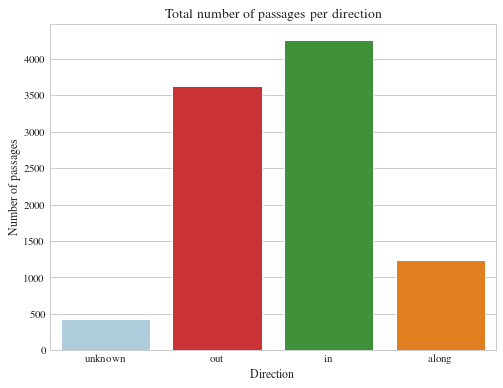

In [25]:
fig, ax = plt.subplots(1, figsize=(8,6))
sns.countplot(x='direction', 
              data=df[df.passage == 1],
              palette=[p[0], p[5], p[3], p[7]],
              ax=ax)
ax.set_title('Total number of passages per direction', fontsize=14)
ax.set_ylabel('Number of passages')
ax.set_xlabel('Direction')

#### Rätt onödig plot, kan ge dessa siffror om du vill ha med det i texten bara istället:

In [26]:
n_unk = len(df[(df.passage == 1) & (df.direction == 'unknown')].index)
n_out = len(df[(df.passage == 1) & (df.direction == 'out')].index)
n_in = len(df[(df.passage == 1) & (df.direction == 'in')].index)
n_along = len(df[(df.passage == 1) & (df.direction == 'along')].index)
n_all = len(df[(df.passage == 1)].index)

In [27]:
print('percentage unknown {:.2f}%'.format(100*n_unk/n_all))
print('percentage out {:.2f}%'.format(100*n_out/n_all))
print('percentage in {:.2f}%'.format(100*n_in/n_all))
print('percentage along {:.2f}%'.format(100*n_along/n_all))

percentage unknown 4.48%
percentage out 37.96%
percentage in 44.64%
percentage along 12.92%


#### Total number of true passages per direction.
Dvs. hur stor andel av alla passager, Passage (1/0/*) = 1, som har skett i riktningarna in och
out, DIR (NUM) = 1 resp 0, har skett i respektive riktning.

Text(0.5, 0, 'Direction')

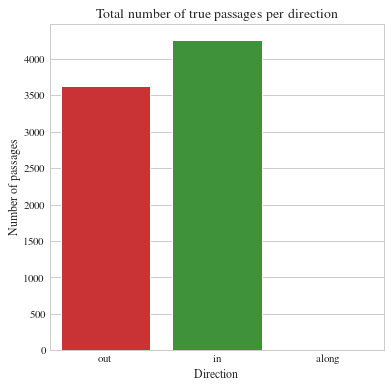

In [28]:
fig, ax = plt.subplots(1, figsize=(6,6))
sns.countplot(x='direction', 
              data=df[
                  (df.passage == 1) &
                  (
                      (df.direction_numerical == 1) |
                      (df.direction_numerical == 0)
                  )
              ],
              palette=[p[5], p[3]],
              ax=ax)
ax.set_title('Total number of true passages per direction', fontsize=14)
ax.set_ylabel('Number of passages')
ax.set_xlabel('Direction')

OBS: Denna plot är typiskt intetsägande - idén med plots är ju att kunna skapa en intuitiv framställning av data som gör att man får en "känsla" för hur saker ligger till. Detta kan likagärna presenteras i text:

In [29]:
len_all = len(df[(df.passage == 1) & ((df.direction_numerical == 1) |
                                  (df.direction_numerical == 0))].index)
len_in = len(df[(df.passage == 1) & (df.direction_numerical == 1)].index)
print(f'all passages count: {len_all}')
print(f'passages going in: {len_in}')
print('fraction going in: {:.3f}%'.format(100*len_in/len_all))

all passages count: 7897
passages going in: 4264
fraction going in: 53.995%


##### "Out of all the 7759 passages where elephants went either in or out, 4169 (53.7%) passages were made in the inward direction" 

### Passager per timme på dygnet.

#### Total number of passages by hour of day.
Dvs. Av alla passager i alla riktningar, hur är dessa fördelade över dygnets olika timmar.

In [30]:
hour_by_dir = df[df.passage == 1]\
                 .groupby(['hour', 'direction'])\
                 .count().reset_index()
hour_by_dir.head(5)

,hour,direction,date,corridor,camera,sex,direction_numerical,group size,passage,luminosity,moon phase
0,0,along,31,31,31,19,0,31,31,31,31
1,0,in,132,132,132,87,132,132,132,132,132
2,0,out,141,141,141,105,141,141,141,141,141
3,0,unknown,11,11,11,6,0,11,11,11,11
4,1,along,18,18,18,17,0,18,18,18,18


In [31]:
# sanity check, passages at `along` in hour 0 should be = 31
len(df[(df.passage == 1) & (df.hour == 0) & (df.direction == 'along')].index)

31

In [32]:
tmp = df[df.passage == 1].groupby('hour').count().reset_index()
tmp['direction'] = 'all'

hour_by_dir = pd.merge(hour_by_dir[['hour', 'date', 'direction']], 
                       tmp[['hour', 'date', 'direction']], 
                       on=['hour', 'date', 'direction'], 
                       how='outer').sort_values(by='hour')

Text(0.5, 0, 'Hour')

/home/max/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


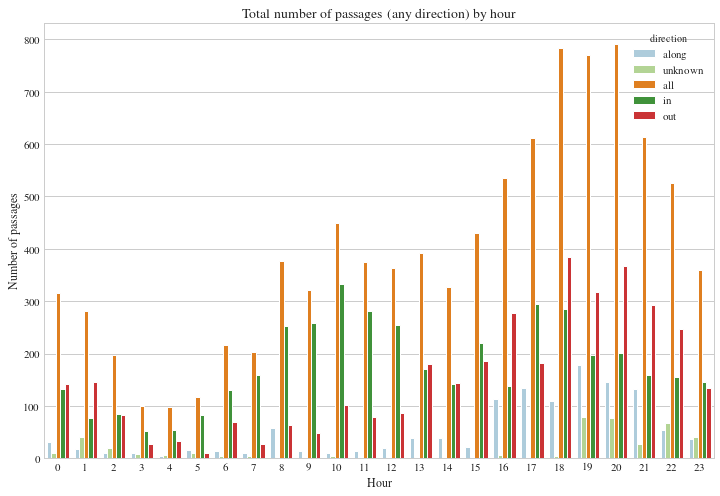

In [33]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='hour', 
            y='date', 
            hue='direction', 
            data=hour_by_dir,
            palette=[p[0], p[2], p[7], p[3], p[5]],
            ax=ax)
ax.set_title('Total number of passages (any direction) by hour', fontsize=14)
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')

### Same plot as lineplot

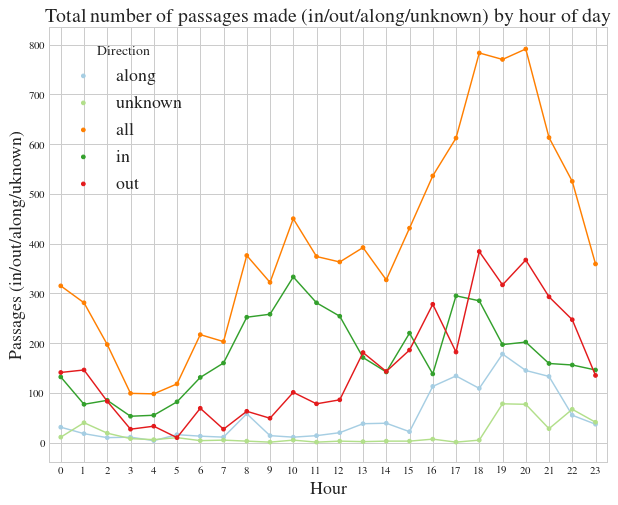

In [367]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction', 
              data=hour_by_dir,
              palette=[p[0], p[2], p[7], p[3], p[5]],
              linewidth=0.2, 
              markersize=20,
              ax=ax)
ax.set_title('Total number of passages made (in/out/along/unknown) by hour of day', fontsize=20)
ax.set_ylabel('Passages (in/out/along/uknown)', fontsize=18)
ax.set_xlabel('Hour', fontsize=18)
plt.legend(title='Direction', fontsize=18)
ax.grid(True)

#### Total number of true passages by hour of day.
Dvs. Samma som ovan men endast för de passager som skett in resp out

In [35]:
true_by_dir = df[(df.passage == 1) & 
                 (df.direction.isin(['in', 'out']))]\
                 .groupby(['hour', 'direction'])\
                 .count().reset_index()
true_by_dir.head(5)

,hour,direction,date,corridor,camera,sex,direction_numerical,group size,passage,luminosity,moon phase
0,0,in,132,132,132,87,132,132,132,132,132
1,0,out,141,141,141,105,141,141,141,141,141
2,1,in,77,77,77,59,77,77,77,77,77
3,1,out,146,146,146,108,146,146,146,146,146
4,2,in,85,85,85,60,85,85,85,85,85


Text(0.5, 0, 'Hour')

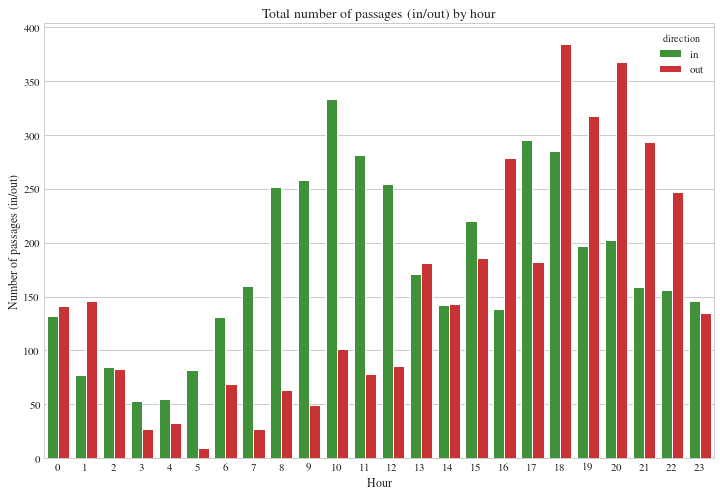

In [36]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='hour', 
            y='date', 
            hue='direction', 
            data=true_by_dir,
            palette=[p[3], p[5]],
            ax=ax)
ax.set_title('Total number of passages (in/out) by hour', fontsize=14)
ax.set_ylabel('Number of passages (in/out)')
ax.set_xlabel('Hour')


### Same plot as lineplot

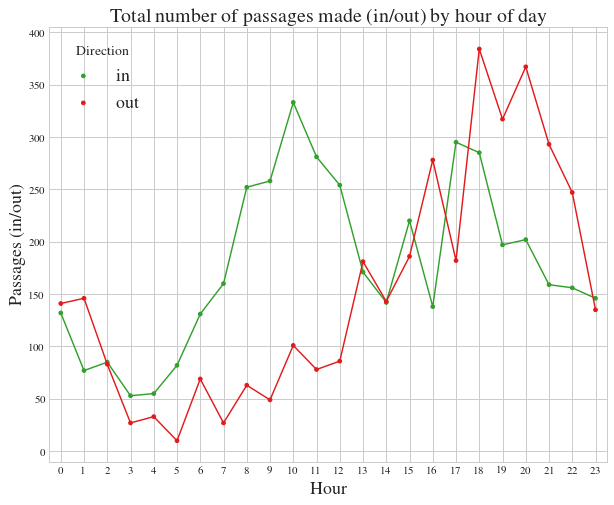

In [371]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction', 
              data=true_by_dir,
              palette=[p[3], p[5]],
              ax=ax)
ax.set_title('Total number of passages made (in/out) by hour of day', fontsize=20)
ax.set_ylabel('Passages (in/out)', fontsize=18)
ax.set_xlabel('Hour', fontsize=18)
plt.legend(title='Direction', fontsize=18)
ax.grid(True)

### Percentage of total number of passages taking place during day versus night.
Dvs. Av alla passager i alla riktningar, hur stor andel sker mellan kl 07:00 tom 19:00 resp
mellan 19:00 tom 07:00.

In [38]:
by_day = df[(df.passage == 1) & 
              ((df.hour >= 7) & (df.hour <= 18))]

by_night = df[(df.passage == 1) & 
                     (
                         ((df.hour <= 6) & (df.hour >= 0)) |
                         ((df.hour >= 19) & (df.hour <= 23))
                     )]
n_all_times = len(by_day.index) + len(by_night.index)

In [39]:
# sanity check
print(f'hours in by_day: {sorted(by_day.hour.unique())}')
print(f'hours in by_night: {sorted(by_night.hour.unique())}')

hours in by_day: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
hours in by_night: [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]


In [40]:
print('Percentage of passages by day {:.2f}%'
      .format(100*len(by_day.index) / n_all_times))
      
print('Percentage of passages by night {:.2f}%'
      .format(100*len(by_night.index) / n_all_times))

Percentage of passages by day 54.11%
Percentage of passages by night 45.89%


### Percentage of total number of true passages taking place during day versus night.

Dvs. Samma som ovan men endast för de passager som skett in resp out.

In [41]:
true = df[(df.passage == 1) & ((df.direction_numerical == 1) |
                               (df.direction_numerical == 0))]

In [42]:
true_by_day = true[(true.passage == 1) & 
              ((true.hour >= 7) & (true.hour <= 18))]

true_by_night = true[(true.passage == 1) & 
                     (
                         ((true.hour <= 6) & (true.hour >= 0)) |
                         ((true.hour >= 19) & (true.hour <= 23))
                     )]
n_both_true = len(true_by_day) + len(true_by_night)

In [43]:
# sanity check
print(f'hours in true_by_day: {sorted(true_by_day.hour.unique())}')
print(f'hours in true_by_night: {sorted(true_by_night.hour.unique())}')

hours in true_by_day: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
hours in true_by_night: [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]


In [44]:
print('Percentage of true passages by day {:.2f}%'
      .format(100*len(true_by_day.index) / n_both_true))
      
print('Percentage of true passages by night {:.2f}%'
      .format(100*len(true_by_night.index) / n_both_true))

Percentage of true passages by day 57.58%
Percentage of true passages by night 42.42%


### Time of in passages.

Dvs. hur är passagerna `in` fördelade på tid på dygnet.

In [45]:
in_pass = df[(df.passage == 1) & (df.direction == 'in')]
in_pass_grouped = in_pass.groupby(['hour', 'direction'])\
                                    .count().reset_index()

Text(0.5, 0, 'Hour')

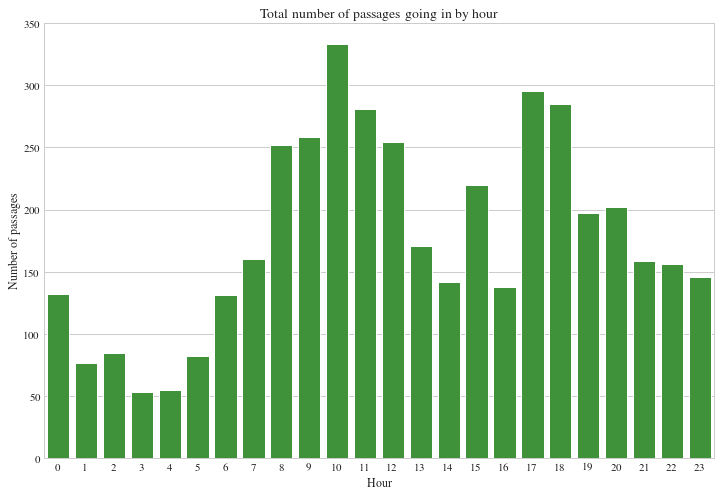

In [46]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='hour', 
            y='date', 
            data=in_pass_grouped,
            palette=[p[3]],
            ax=ax)
ax.set_title('Total number of passages going in by hour', fontsize=14)
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')

### Same plot as lineplot

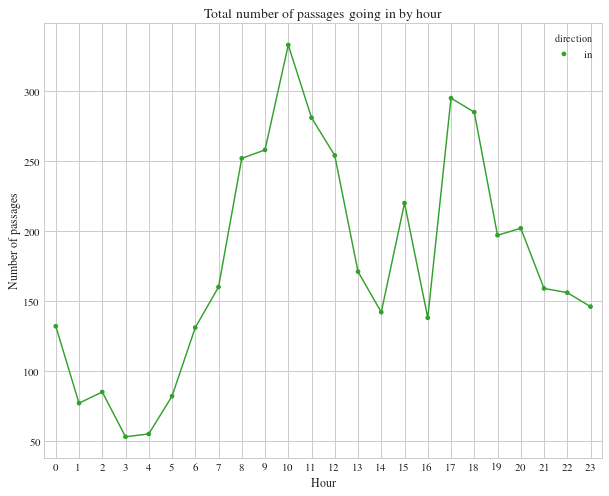

In [47]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction',
              data=in_pass_grouped,
              palette=[p[3]],
              ax=ax)
ax.set_title('Total number of passages going in by hour', fontsize=14)
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')
ax.grid(True)

### Time of out passages.
Dvs. hur är passagerna in fördelade på tid på dygnet.

In [48]:
out_pass = df[(df.passage == 1) & (df.direction == 'out')]
out_pass_grouped = out_pass.groupby(['hour', 'direction'])\
                                    .count().reset_index()

Text(0.5, 0, 'Hour')

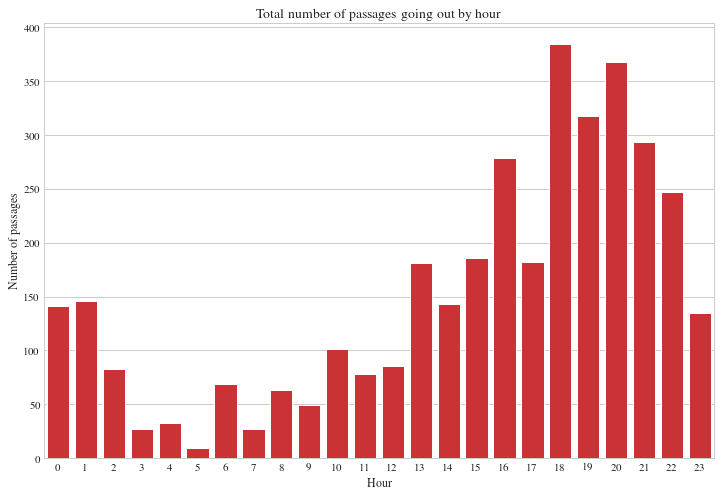

In [49]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='hour', 
            y='date', 
            data=out_pass_grouped,
            palette=[p[5]],
            ax=ax)
ax.set_title('Total number of passages going out by hour', fontsize=14)
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')

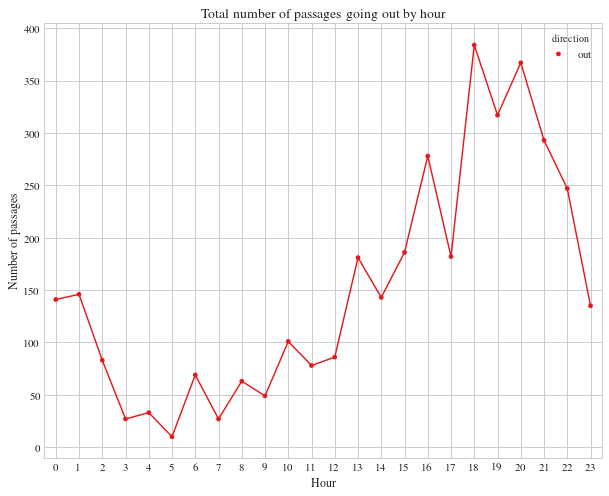

In [50]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction',
              data=out_pass_grouped,
              palette=[p[5]],
              ax=ax)
ax.set_title('Total number of passages going out by hour', fontsize=14)
ax.set_ylabel('Number of passages')
ax.set_xlabel('Hour')
ax.grid(True)

OBS: Båda dessa plots med passages in/out har redan visats i tidigare plots, båda i de som täcker alla directions och de som bara visar in/out. Överflödiga att ha med förmodligen. Kanske vill du ha de side-by-side för någon diskussion dock, men ändå konstigt att visa samma sak flera gånger. Kan visas i samm grid nedan:

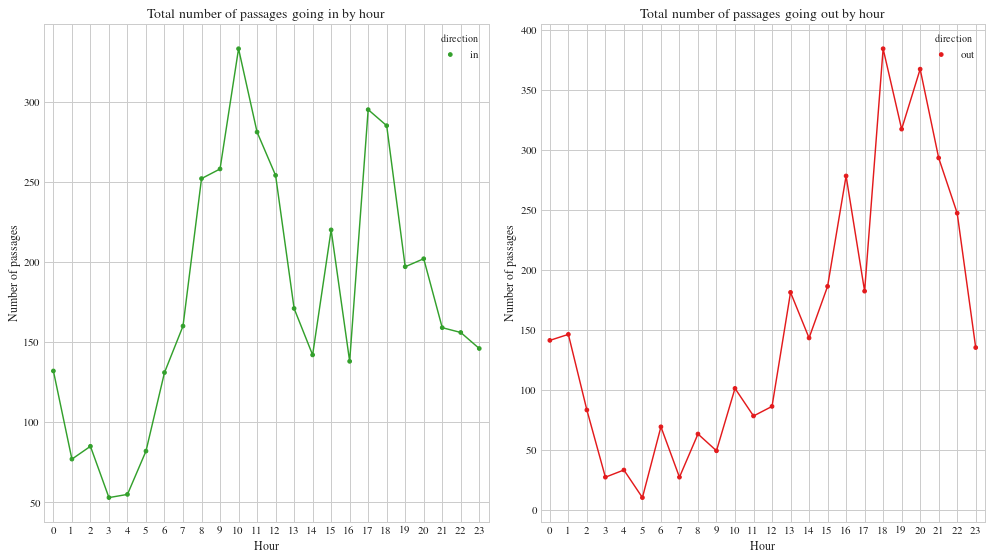

In [51]:
fig, axes = plt.subplots(1,2, figsize=(14,8))
axes = axes.flatten()

sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction',
              data=in_pass_grouped,
              palette=[p[3]],
              ax=axes[0])
axes[0].set_title('Total number of passages going in by hour', fontsize=14)
axes[0].set_ylabel('Number of passages')
axes[0].set_xlabel('Hour')
axes[0].grid(True)

sns.set_context(rc={"lines.linewidth": 0.8})
sns.pointplot(x='hour', 
              y='date', 
              hue='direction',
              data=out_pass_grouped,
              palette=[p[5]],
              ax=axes[1])
axes[1].set_title('Total number of passages going out by hour', fontsize=14)
axes[1].set_ylabel('Number of passages')
axes[1].set_xlabel('Hour')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Genomsnittsantal passager per dag fördelat på kalendermånader 
(alla tre åren tillsammans plus var och en för sig).

In [52]:
df['year_month'] = df['date'].apply(lambda t: t.strftime('%Y-%m'))
df['month_day'] = df['date'].apply(lambda t: t.strftime('%m-%d'))
df['month'] = df['date'].apply(lambda t: t.strftime('%m'))
df['day'] = df['date'].apply(lambda t: t.strftime('%d'))

### Vi kan börja med mean passages per month, med err-bars för konfidensintervall .95.

Förklaring av konfidensintervall:

För "mean" estimatorn (medelvärdet) räknas konfidensintervallet ut som:

$\bar{x} \pm 1.96\sigma / \sqrt{n}$

Där $\bar{x}$ är uträknade medelvärdet i ditt sample, $ n $ är antalet observationer i ditt sample och $\sigma$ är standardavvikelsen. Det du uppskattar är alltså osäkerheten av medelvärdet _i populationen_ (dvs alla värden som kan tänkas finnas, inte bara de du har att jobba med) givet ditt sample. Som du ser är det beroende av spridningen ($\sigma$) och hur många observationer du har ($n$). Om du har stor spridning, ja då blir $\sigma$ stort och osäkerheten på din uppskattning av medelvärdet större. På samma sätt blir din osäkerhet mindre ju fler observationer du har ($\sqrt{n}$ blir större), och din osäkerhet minskar, eftersom vi delar $1.96\sigma $ med $\sqrt{n}$.

Värdet $1.96$ kommer från att vi därmed täcker 95% av sannolikhetsfördelningen (vi är 95% säkra på att det sanna medelvärden ligger någonstans plus/minus $1.96\sigma / \sqrt{n}$ från vårt uppskattade medelvärde $\bar{x}$.

En förutsättning för att detta ska funka är att distributionen av medelvärden är normalfördelad när vi tar samples från den sanna distributionen, vilket du kan anta att den är vid ett stort antal observationer tack vare [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

#### Start by taking mean of each month, all years, as barplot with CI=0.95

In [53]:
# drop passage == '*' vi kan inte summera '*', måste vara siffror
# vi tar bort direction == 0 också, för det verkar vara saknad/dålig data
df_drop = df[(df.passage != '*') & (df.direction != 0)]
#df_drop = df[df.direction != 0]
df_drop.loc[:, 'passage'] = df_drop['passage'].astype(int)

/home/max/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [54]:
month_names = {
    '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October',
    '11': 'November',
    '12': 'December'
}

In [55]:
def add_missing_dates(summed_df):
    """Only input df with columns `date` and summed `passage`"""
    input_date = summed_df['date'].min()
    last_date = summed_df['date'].max()
    all_dates = list(summed_df['date'])
    to_add = list()
    
    while input_date != last_date:
        if input_date not in all_dates:
            to_add.append([input_date, 0])
        input_date += pd.to_timedelta(1, unit='d')
        
    summed_df = summed_df.append(pd.DataFrame(data=to_add, columns=['date', 'passage']))
    
    summed_df['year'] = summed_df['date'].apply(lambda t: t.strftime('%Y'))
    summed_df['month'] = summed_df['date'].apply(lambda t: t.strftime('%m'))
    summed_df['year_month'] = summed_df['date'].apply(lambda t: t.strftime('%Y-%m'))
    
    summed_df['proper_month'] = pd.Series()
    for k,v in month_names.items():
        summed_df.loc[summed_df['month'] == k, 'proper_month'] = v
    
    summed_df = summed_df.sort_values(by='date')

    return summed_df

Nu har vi alltså summerat alla passager för varje datum, sen tar vi medelvärdet av alla dags-summor för varje månad. De svarta sträcken representerar .95 konfidensintervallets övre och undre gräns (dvs vi är 95% säkra på att det sanna medelvärdet ligger någonstans mellan dessa de svarta sträcken).

Johanna föredrog proper names för månaderna istället för siffror, kanske ser bättre ut?

In [56]:
month_sum = df_drop.groupby('date').sum().reset_index()

month_sum['year'] = month_sum['date'].apply(lambda t: t.strftime('%Y'))
month_sum['month'] = month_sum['date'].apply(lambda t: t.strftime('%m'))
month_sum['year_month'] = month_sum['date'].apply(lambda t: t.strftime('%Y-%m'))

month_sum['proper_month'] = pd.Series()
for k,v in month_names.items():
    month_sum.loc[month_sum['month'] == k, 'proper_month'] = v
    
ms_copy = month_sum.copy() # copy for later
# month_sum['year'] = month_sum['date'].apply(lambda t: t.strftime('%Y'))
# month_sum['month'] = month_sum['date'].apply(lambda t: t.strftime('%m'))
# month_sum['year_month'] = month_sum['date'].apply(lambda t: t.strftime('%Y-%m'))

In [57]:
month_sum = add_missing_dates(month_sum[['date', 'passage']])

/home/max/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


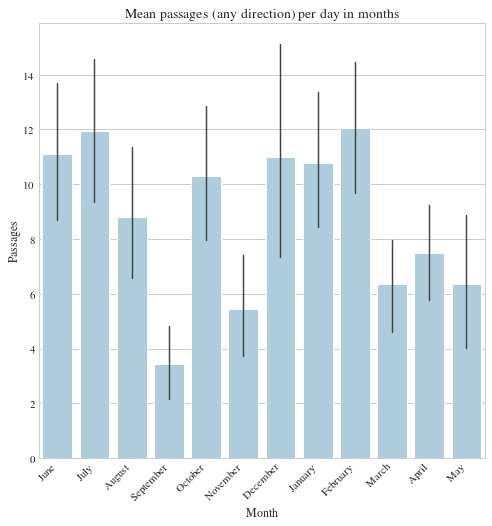

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='proper_month', 
            y='passage', 
            data=month_sum,#.sort_values(by='month'),
            ci=95, 
            palette=[palette[0]])
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
ax.set_title('Mean passages (any direction) per day in months', fontsize=14)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)

### Med färgskala:

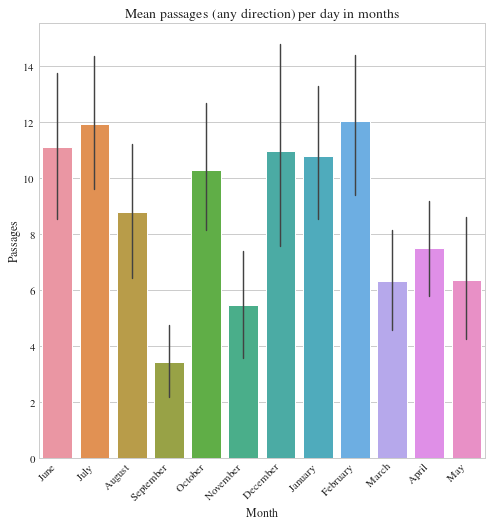

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='proper_month', 
            y='passage', 
            data=month_sum,#.sort_values(by='month'),
            ci=95)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
ax.set_title('Mean passages (any direction) per day in months', fontsize=14)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)

### Split by year

In [60]:
month_sum.year.unique()

array(['2015', '2016', '2017', '2018'], dtype=object)

In [61]:
month_sum[(month_sum.year == '2015')].month.unique()

array(['06', '07', '08', '09', '10', '11', '12'], dtype=object)

In [62]:
month_sum.head()

,date,passage,year,month,year_month,proper_month
0,2015-06-02,6,2015,06,2015-06,June
1,2015-06-03,3,2015,06,2015-06,June
2,2015-06-04,11,2015,06,2015-06,June
0,2015-06-05,0,2015,06,2015-06,June
3,2015-06-06,6,2015,06,2015-06,June


In [63]:
first_half = ['01', '02', '03', '04', '05']
second_half = ['06', '07', '08', '09', '10', '11', '12']

In [64]:
year_dfs = [
    month_sum[
        (month_sum.year == '2015') | ((month_sum.year == '2016') & (month_sum.month.isin(first_half)))
    ],
    month_sum[
        ((month_sum.year == '2016') & (month_sum.month.isin(second_half))) |
        ((month_sum.year == '2017') & (month_sum.month.isin(first_half)))
    ],
    month_sum[
        ((month_sum.year == '2017') & (month_sum.month.isin(second_half))) |
        (month_sum.year == '2018')
    ]
]

/home/max/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/max/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


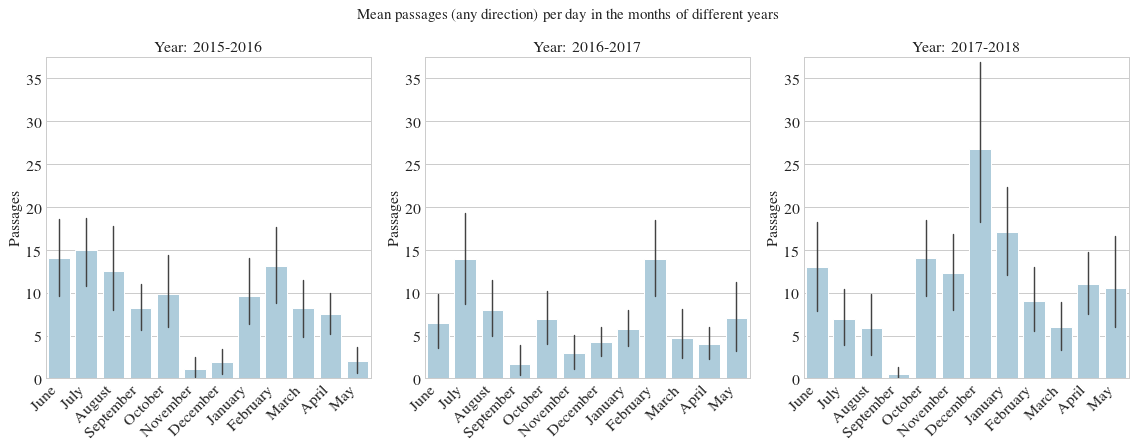

In [65]:
fig, axes = plt.subplots(1,3, figsize=(16,6))
axes = axes.flatten()
fig.suptitle(
    'Mean passages (any direction) per day in the months of different years',
    fontsize=15,
    y=1.04
)

for ax, y_df in zip(axes, year_dfs):
    sns.barplot(x='proper_month', 
            y='passage', 
            data=y_df,
            ci=95, 
            palette=[palette[0]],
            ax=ax)
    this_year = '-'.join(y_df['year'].unique())
    ax.set_xlabel('')
    ax.set_ylabel('Passages', fontsize=16)
    ax.set_title(
        f'Year: {this_year}', fontsize=16)
    labels = ax.xaxis.get_majorticklabels() 
    ax.set_xticklabels(labels, rotation=45, ha='right', minor=False, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylim([0, 37.5])
    #ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

### Med färgskala:

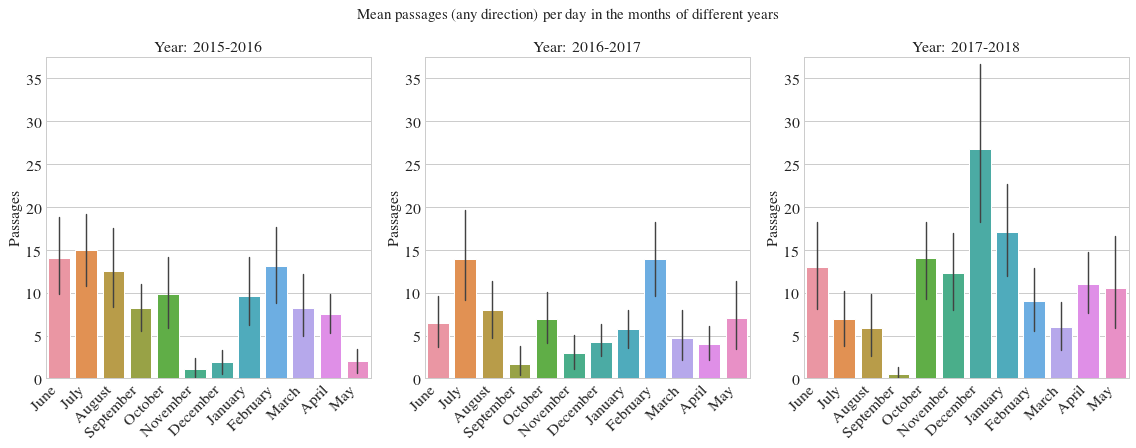

In [66]:
fig, axes = plt.subplots(1,3, figsize=(16,6))
axes = axes.flatten()
fig.suptitle(
    'Mean passages (any direction) per day in the months of different years',
    fontsize=15,
    y=1.04
)

for ax, y_df in zip(axes, year_dfs):
    sns.barplot(x='proper_month', 
            y='passage', 
            data=y_df,
            ci=95,
            ax=ax)
    this_year = '-'.join(y_df['year'].unique())
    ax.set_xlabel('')
    ax.set_ylabel('Passages', fontsize=16)
    ax.set_title(
        f'Year: {this_year}', fontsize=16)
    labels = ax.xaxis.get_majorticklabels() 
    ax.set_xticklabels(labels, rotation=45, ha='right', minor=False, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylim([0, 37.5])
    #ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

### Mean number of true passages taking place per day by month of the year.

Så gör vi allt igen bara för "true" passages..

In [67]:
df_only_true = df_drop[
    (df_drop.direction == 'in') |
    (df_drop.direction == 'out')
]

In [68]:
month_sum_true = df_only_true.groupby('date').sum().reset_index()
month_sum_true['year'] = month_sum_true['date'].apply(lambda t: t.strftime('%Y'))
month_sum_true['month'] = month_sum_true['date'].apply(lambda t: t.strftime('%m'))
month_sum_true['year_month'] = month_sum_true['date'].apply(lambda t: t.strftime('%Y-%m'))
month_sum_true['proper_month'] = pd.Series()
for k,v in month_names.items():
    month_sum_true.loc[month_sum_true['month'] == k, 'proper_month'] = v
    
ms_true_copy = month_sum_true.copy()
# month_sum_true['year'] = month_sum_true['date'].apply(lambda t: t.strftime('%Y'))
# month_sum_true['month'] = month_sum_true['date'].apply(lambda t: t.strftime('%m'))
# month_sum_true['year_month'] = month_sum_true['date'].apply(lambda t: t.strftime('%Y-%m'))

In [69]:
month_sum_true = add_missing_dates(month_sum_true[['date', 'passage']])

(0, 22.5)

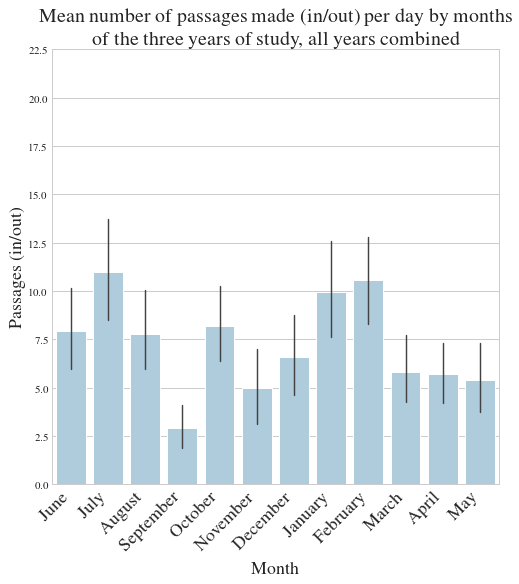

In [390]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='proper_month', 
            y='passage', 
            data=month_sum_true,#.sort_values(by='month'),
            ci=95, 
            palette=[palette[0]])
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Passages (in/out)', fontsize=18)
ax.set_title('Mean number of passages made (in/out) per day by months \n of the three years of study, all years combined', 
             fontsize=20)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False, fontsize=18)
ax.set_ylim([0, 22.5])

### Med färgskala:

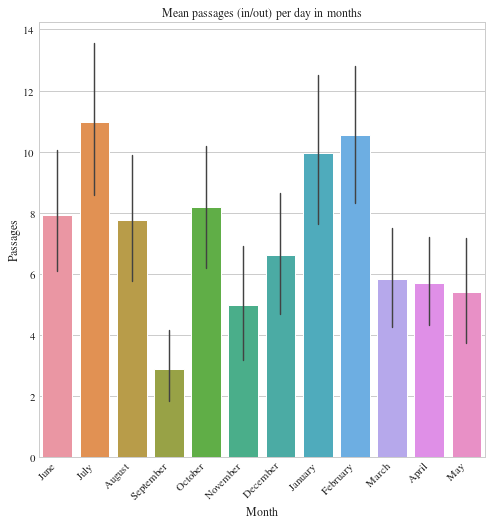

In [75]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='proper_month', 
            y='passage', 
            data=month_sum_true,#.sort_values(by='month'),
            ci=95)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
ax.set_title('Mean passages (in/out) per day in months')
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)

In [377]:
year_dfs = [
    month_sum_true[
        (month_sum_true.year == '2015') | ((month_sum_true.year == '2016') & (month_sum_true.month.isin(first_half)))
    ],
    month_sum_true[
        ((month_sum_true.year == '2016') & (month_sum_true.month.isin(second_half))) |
        ((month_sum_true.year == '2017') & (month_sum_true.month.isin(first_half)))
    ],
    month_sum_true[
        ((month_sum_true.year == '2017') & (month_sum_true.month.isin(second_half))) |
        (month_sum_true.year == '2018')
    ]
]

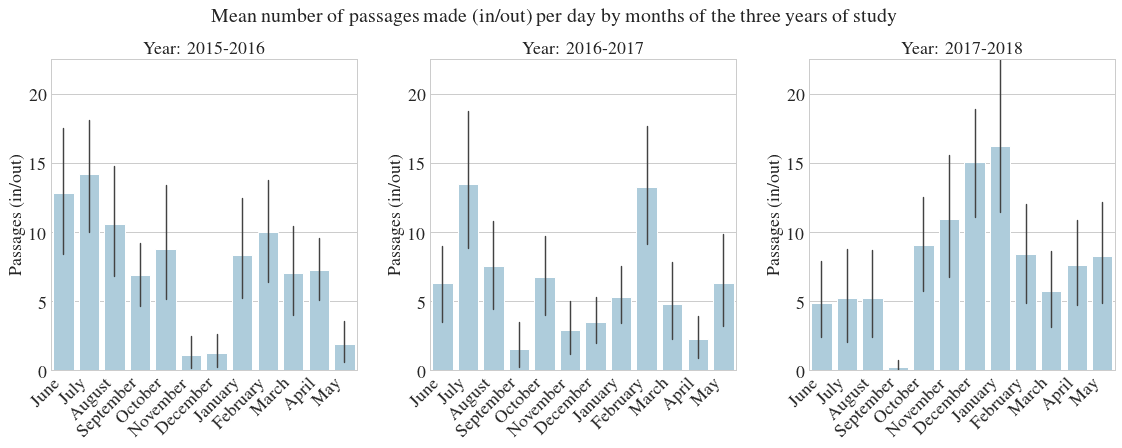

In [388]:
fig, axes = plt.subplots(1,3, figsize=(16,6))
axes = axes.flatten()
fig.suptitle(
    'Mean number of passages made (in/out) per day by months of the three years of study',
    fontsize=20,
    y=1.04
)
for ax, y_df in zip(axes, year_dfs):
    sns.barplot(x='proper_month', 
            y='passage', 
            data=y_df,
            ci=95, 
            palette=[palette[0]],
            ax=ax)
    this_year = '-'.join(y_df['year'].unique())
    ax.set_xlabel('')
    ax.set_ylabel('Passages (in/out)', fontsize=18)
    ax.set_title(
        f'Year: {this_year}', fontsize=18)
    labels = ax.xaxis.get_majorticklabels() 
    ax.set_xticklabels(labels, rotation=45, ha='right', minor=False, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylim([0, 22.5])
    #ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

### Med färgskala:

/home/max/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


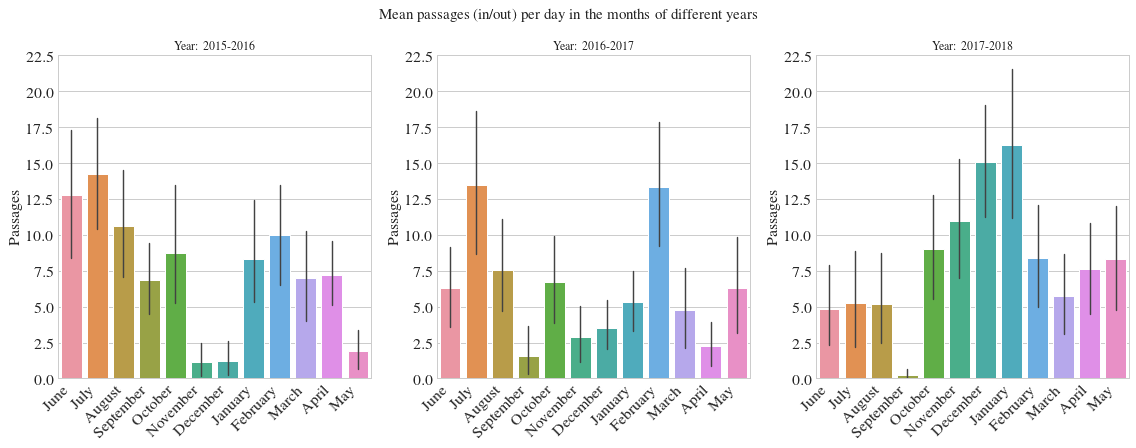

In [78]:
fig, axes = plt.subplots(1,3, figsize=(16,6))
axes = axes.flatten()
fig.suptitle(
    'Mean passages (in/out) per day in the months of different years',
    fontsize=15,
    y=1.04
)
for ax, y_df in zip(axes, year_dfs):
    sns.barplot(x='proper_month', 
            y='passage', 
            data=y_df,
            ci=95,
            ax=ax)
    this_year = '-'.join(y_df['year'].unique())
    ax.set_xlabel('')
    ax.set_ylabel('Passages', fontsize=16)
    ax.set_title(
        f'Year: {this_year}')
    labels = ax.xaxis.get_majorticklabels() 
    ax.set_xticklabels(labels, rotation=45, ha='right', minor=False, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylim([0, 22.5])
    #ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

## Vi kan även göra boxplots för att se distributionerna per månad för passager

Om du inte är bekant med boxplots så är mittensträcket medianen, storleken på boxarna är där all data i storlekarna 25%-75% finns, och wiskers (sträcken) är toppen/botten på boxen plus 1.5 * boxens storlek. Punkterna (diamanterna) ovan/under är outliers som inte täcks in inom dessa intervall.

[Förklaras på denna länk](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

### All directions
#### Samma boxplots visas nedan med/utan färgskala:

Text(0, 0.5, 'Passages')

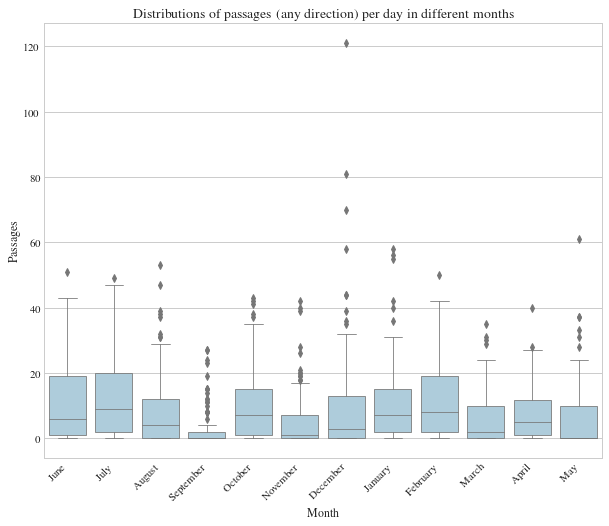

In [79]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='proper_month', 
            y='passage',
            data=month_sum,#.sort_values(by='month'),
            palette=[palette[0]],
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (any direction) per day in different months', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

Text(0, 0.5, 'Passages')

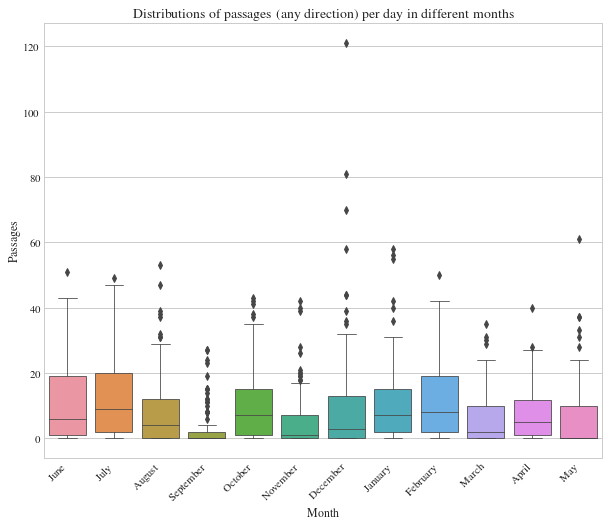

In [80]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='proper_month', 
            y='passage',
            data=month_sum,#.sort_values(by='month'), 
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (any direction) per day in different months', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

### Only true directions

Text(0, 0.5, 'Passages')

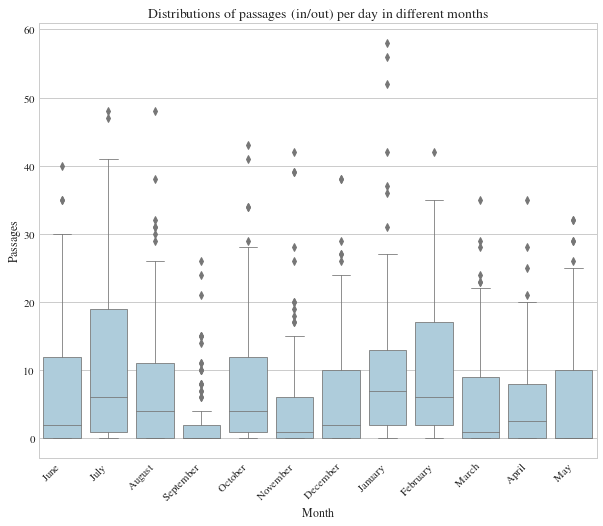

In [81]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='proper_month', 
            y='passage',
            data=month_sum_true,#.sort_values(by='month'),
            palette=[palette[0]],
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

Text(0, 0.5, 'Passages')

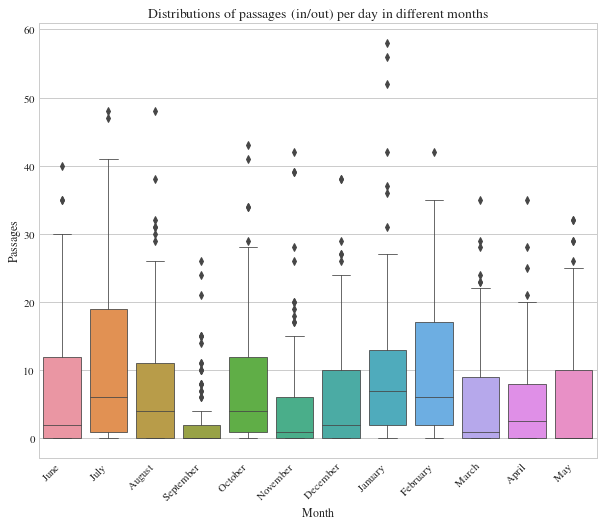

In [82]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='proper_month', 
            y='passage',
            data=month_sum_true,#.sort_values(by='month'), 
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

### Split by in/out in boxplots

In [83]:
month_sum_true = ms_true_copy.copy()
month_sum = ms_copy.copy()

In [84]:
hax = month_sum_true.copy()

In [85]:
hax['direction'] = pd.Series()
hax.loc[hax.direction_numerical > 0, 'direction'] = 'in'
hax.loc[hax.direction_numerical == 0, 'direction'] = 'out'

Text(0, 0.5, 'Passages')

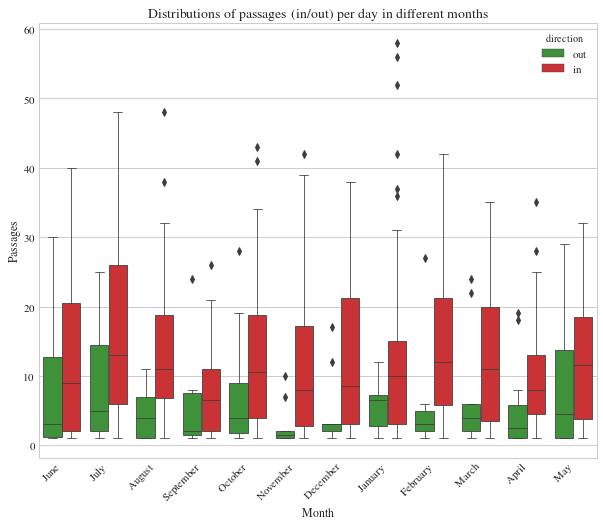

In [86]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='proper month', 
            y='passage',
            hue='direction',
            data=hax.rename(index=str, columns={'proper_month': 'proper month'}),#.sort_values(by='month'),
            palette=[p[3], p[5]],
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')

### Vi kan även få alla observationer plottade

### All directions

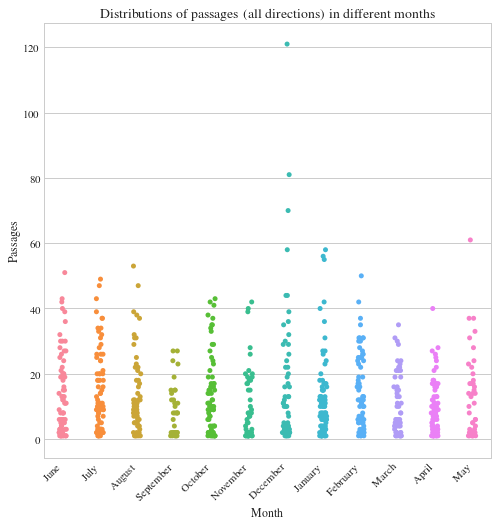

In [87]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.catplot(x='proper month', 
            y='passage', 
            data=month_sum.rename(index=str, columns={'proper_month': 'proper month'}),
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (all directions) in different months', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
plt.close(2) 

### Only in/out (true directions)

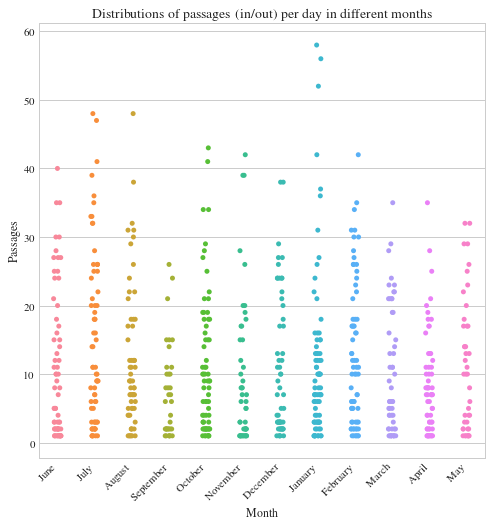

In [88]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.catplot(x='proper month', 
            y='passage', 
            data=month_sum_true.rename(index=str, columns={'proper_month': 'proper month'}),
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
plt.close(2) 

### Split by in/out direction

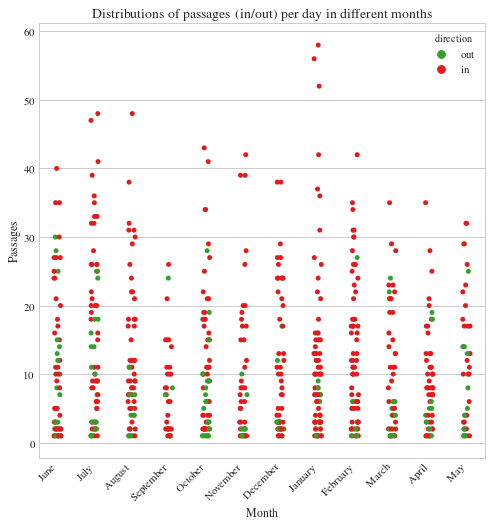

In [89]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.catplot(x='proper month', 
            y='passage',
            hue='direction',
            data=hax.rename(index=str, columns={'proper_month': 'proper month'}),
            palette=[p[3], p[5]],
            ax=ax)
labels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(labels, rotation=45, ha='right', minor=False)
ax.set_title('Distributions of passages (in/out) per day in different months', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Passages')
plt.close(2) 

### Vi kan även plotta alla datapunkter direkt, och titta på konfidensintervall runt mean estimates för varje månad

In [90]:
import datetime

In [91]:
# already sorted by date, nice
all(month_sum['date'] == sorted(month_sum['date']))

True

In [92]:
ts = [datetime.date(t.year, t.month, t.day) for t in month_sum['date']]
ys = [p for p in month_sum['passage']]

In [93]:
d = pd.DataFrame({'t': ts, 'Passages': ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))

#### Alla dina datapunkter plottade, finns en riktig outlier där runt 2018-01

Text(0, 0.5, 'Passages')

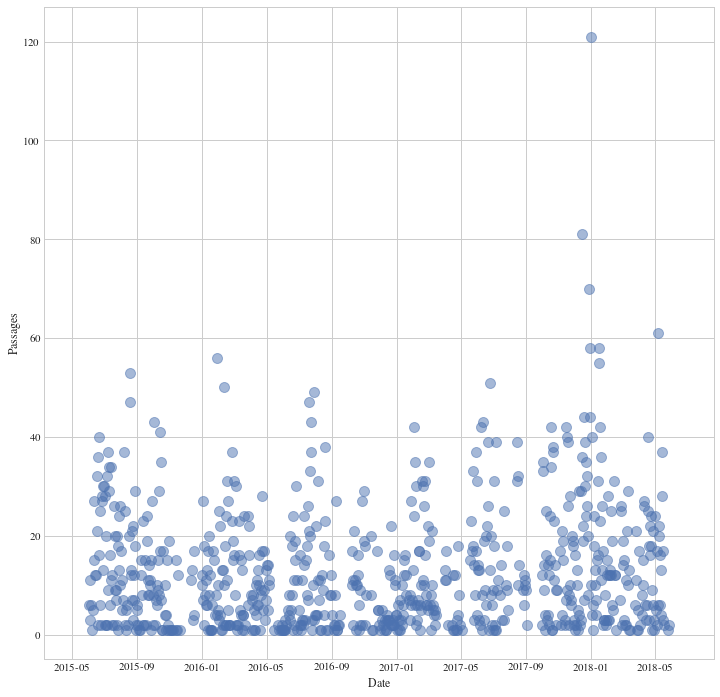

In [94]:
fig, ax = plt.subplots(1, figsize=(12,12))
plt.scatter(ts, ys, alpha=0.5, s=100)
plt.xlabel('Date')
plt.ylabel('Passages')

### Distributionen av datan som en density probability estimation.

Density är ett mått på täthet, dvs distributionen av data och hur "tät" den är runt vissa värden, dvs hur många datapunkter finns runt vissa värden:

[Länk till wiki](https://en.wikipedia.org/wiki/Kernel_density_estimation)

Ser ut som en [exponential distribution](https://stephens999.github.io/fiveMinuteStats/figure/inverse_transform_sampling.Rmd/unnamed-chunk-2-1.png) 

Text(0.5, 1.0, 'Distribution of daily passages (all directions)')

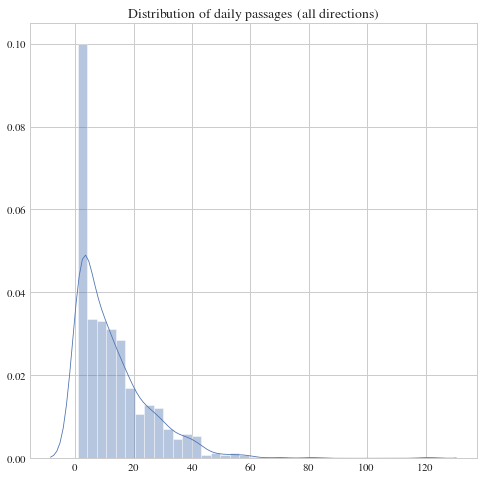

In [95]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.distplot(ys, ax=ax)
ax.set_title('Distribution of daily passages (all directions)', fontsize=14)

### Konfidensband runt vår data

I plotten nedan ser vi alla datapunkter över tid som blåa prickar. De gröna banden är baserade på uppskattningen av medelvärden _för varje månad_. Den övre och undre gränsen är alltså _hur säkra vi är_ på uppskattningen av medelvärdet för datapunkterna som befinner sig inom samma månad. Det blir alltså ett mått på hur stor spridning och hur många datapunkter som finns inom varje månadsintervall, eftersom det är vad som bestämmer den övre- och undre gränsen för intervallet. Som vi minns bestäms gränserna av: 

$\bar{x} \pm 1.96\sigma / \sqrt{n}$


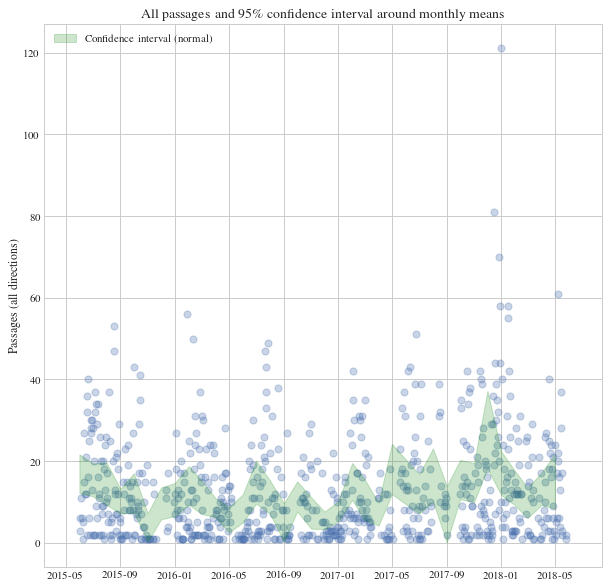

In [96]:
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = np.mean(series), np.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    plt.fill_between(groups, 
                     lo_bound, 
                     hi_bound, 
                     alpha=0.2,
                     label='Confidence interval (normal)',
                     color='green')

plt.figure(figsize=(10,10))
plt.scatter(ts, ys, alpha=0.3, s=50)
observations_by_month = {}
for month, y in zip(d['Month'], d['Passages']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)
plt.ylabel('Passages (all directions)')
plt.title('All passages and 95\% confidence interval around monthly means', fontsize=14)
plt.legend(loc='upper left')

### Same plot with only true (in/out) directions

Samma plots kommer nedan med bara in/out passages.

In [97]:
ts = [datetime.date(t.year, t.month, t.day) for t in month_sum_true['date']]
ys = [p for p in month_sum_true['passage']]

d = pd.DataFrame({'t': ts, 'Passages': ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))

Text(0.5, 1.0, 'Distribution of daily passages (in/out)')

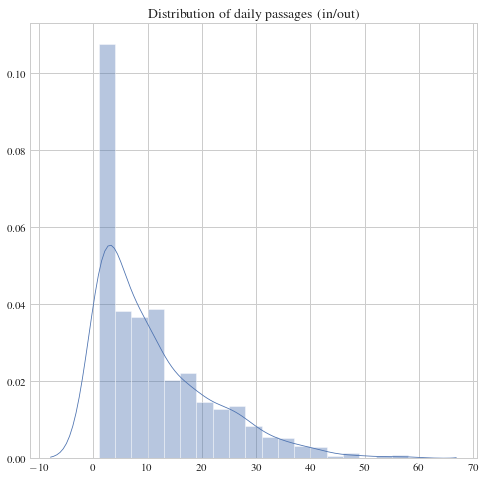

In [98]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.distplot(ys, ax=ax)
ax.set_title('Distribution of daily passages (in/out)', fontsize=14)

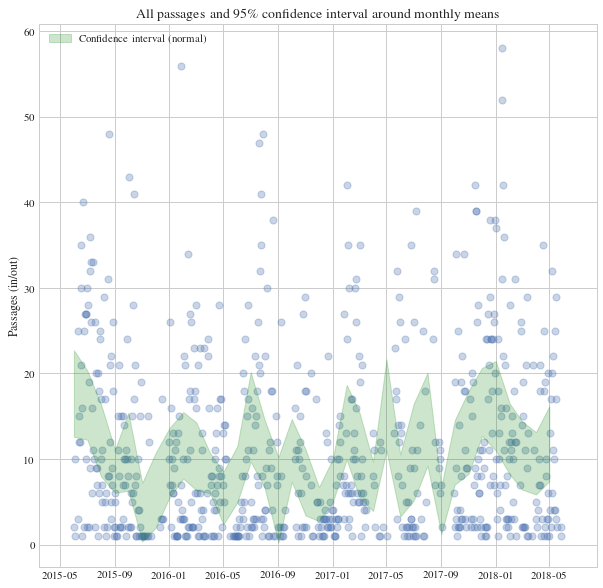

In [99]:
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = np.mean(series), np.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    plt.fill_between(groups, 
                     lo_bound, 
                     hi_bound, 
                     alpha=0.2,
                     label='Confidence interval (normal)',
                     color='green')

plt.figure(figsize=(10,10))
plt.scatter(ts, ys, alpha=0.3, s=50)
observations_by_month = {}
for month, y in zip(d['Month'], d['Passages']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)
plt.ylabel('Passages (in/out)')
plt.title('All passages and 95\% confidence interval around monthly means', fontsize=14)
plt.legend(loc='upper left')

### Man kan även göra en heatmap över passager per månad och timme

In [100]:
hour_month = df_drop.groupby(['month', 'hour'], sort=False).sum()['passage'].reset_index()

In [101]:
hour_month.head()

,month,hour,passage
0,06,9,27
1,06,10,59
2,06,20,34
3,06,23,22
4,06,2,20


In [102]:
pivoted = hour_month.pivot('hour', 'month', 'passage')

In [103]:
pivoted.fillna(0, inplace=True)

In [104]:
piv2 = pivoted.sort_values(by='hour', ascending=False)

/home/max/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


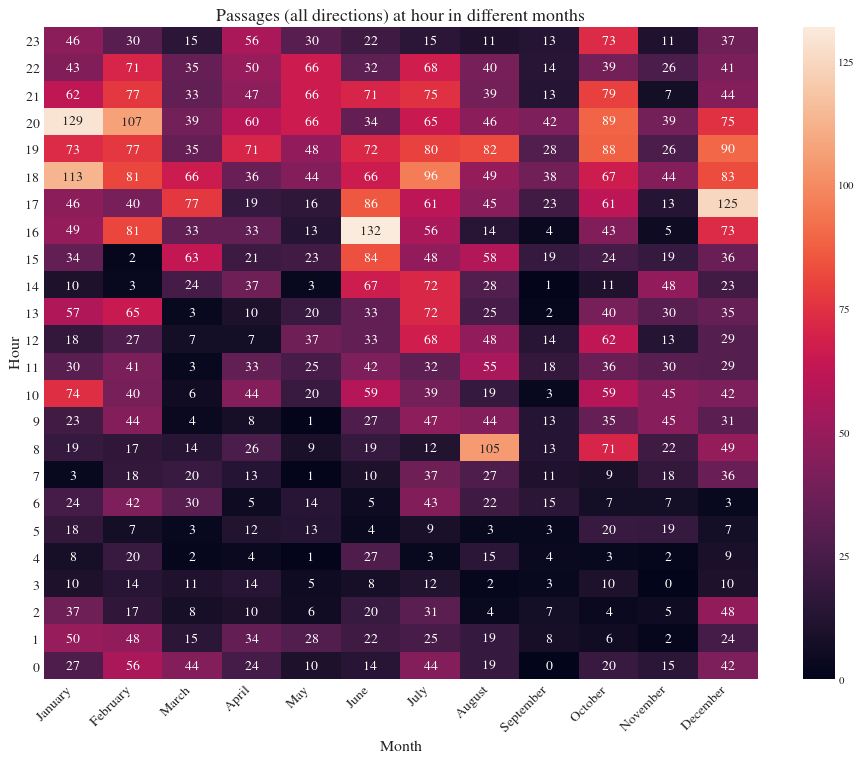

In [105]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(piv2, ax=ax, annot=True, fmt='g')
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Hour', fontsize=16)
ax.set_title('Passages (all directions) at hour in different months', fontsize=18)
ax.set_xticklabels(
    ['January','February','March','April','May',
     'June','July','August','September','October',
     'November','December']
)
xlabels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(xlabels, 
                     rotation=45, 
                     ha='right',
                     fontsize=14,
                     minor=False)
ylabels = ax.yaxis.get_majorticklabels() 
_=ax.set_yticklabels(ylabels, 
                     rotation=0, 
                     ha='right',
                     fontsize=14,
                     minor=False)

## Only in/out in heatmap

In [106]:
hour_month_true = df_only_true.groupby(['month', 'hour'], sort=False).sum()['passage'].reset_index()
pivoted_true = hour_month_true.pivot('hour', 'month', 'passage')

In [107]:
piv_true = pivoted_true.sort_values(by='hour', ascending=False)

In [108]:
piv_true.fillna(0, inplace=True)

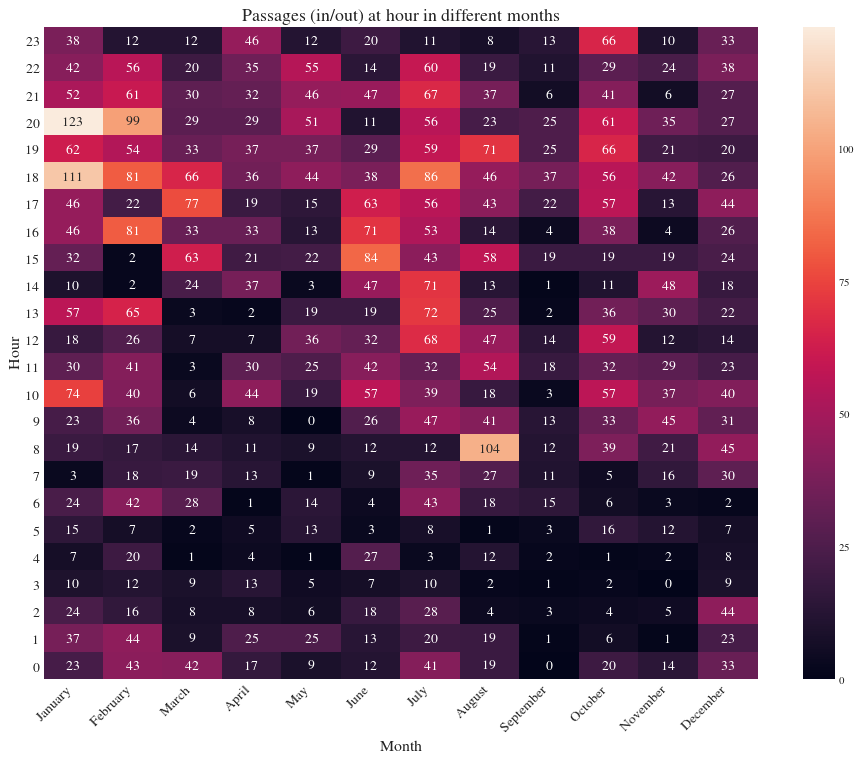

In [109]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(piv_true, ax=ax, annot=True, fmt='g')
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Hour', fontsize=16)
ax.set_title('Passages (in/out) at hour in different months', fontsize=18)
ax.set_xticklabels(
    ['January','February','March','April','May',
     'June','July','August','September','October',
     'November','December']
)
xlabels = ax.xaxis.get_majorticklabels() 
_=ax.set_xticklabels(xlabels, 
                     rotation=45, 
                     ha='right',
                     fontsize=14,
                     minor=False)
ylabels = ax.yaxis.get_majorticklabels() 
_=ax.set_yticklabels(ylabels, 
                     rotation=0, 
                     ha='right',
                     fontsize=14,
                     minor=False)

## Passager per gruppstorlek

#### Total number of passages sorted by group size

In [110]:
g_size = df_drop.groupby('group size').sum().reset_index()

In [398]:
mypal = sns.color_palette("BuGn_r", 50)

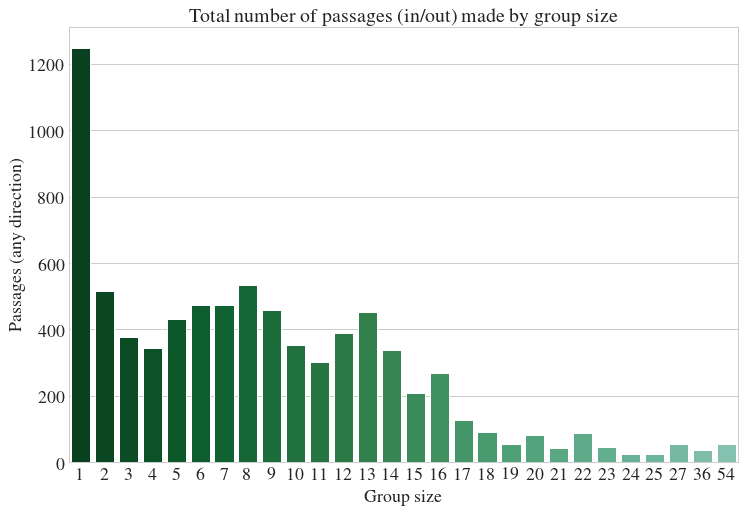

In [399]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='group size', 
            y='passage', 
            data=g_size_true,
            palette=mypal,
            ax=ax)
ax.set_title('Total number of passages (in/out) made by group size', fontsize=20)
ax.set_xlabel('Group size', fontsize=18)
ax.set_ylabel('Passages (any direction)', fontsize=18)
labels = ax.xaxis.get_majorticklabels() 
ax.set_xticklabels(labels, rotation=0, ha='center', minor=False, fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

### Only in/out

In [112]:
g_size_true = df_only_true.groupby('group size').sum().reset_index()

Text(0, 0.5, 'Passages (in/out)')

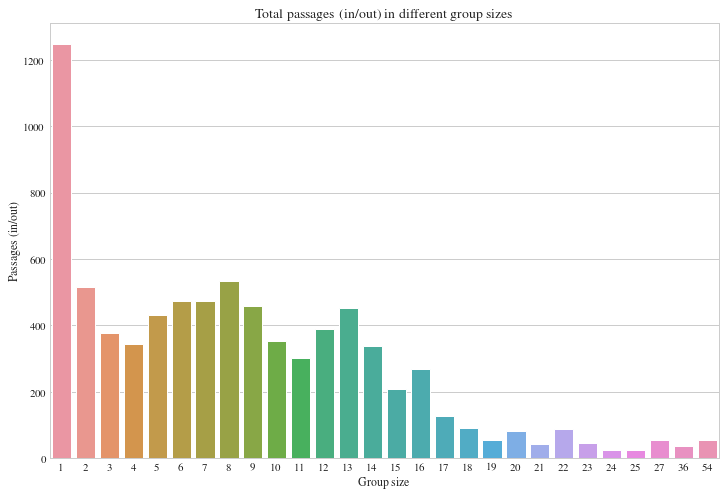

In [113]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='group size', 
            y='passage', 
            data=g_size_true,
            ax=ax)
ax.set_title('Total passages (in/out) in different group sizes', fontsize=14)
ax.set_xlabel('Group size')
ax.set_ylabel('Passages (in/out)')

##### Knappt så man ser nån skillnad mellan in/out och andra (de är dock annorlunda, se grupp 17+18 t.ex)..

## Mean group size?


In [114]:
print('mean group size all directions: {:.3f}'
      .format(df_drop['group size'].mean()))

mean group size all directions: 8.111


In [115]:
print('mean group size in/out directions: {:.3f}'
      .format(df_only_true['group size'].mean()))

mean group size in/out directions: 8.657


## Passager per kön

### Total number of passages sorted by sex (male/female/unknown)

In [116]:
df_drop.loc[:, 'sex'] = df_drop['sex'].str.lower()
df_drop.loc[df_drop.sex == 'u ', 'sex'] = 'u'

/home/max/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [117]:
sex_all = df_drop.groupby('sex').sum().reset_index()

Text(0, 0.5, 'Passages (all directions)')

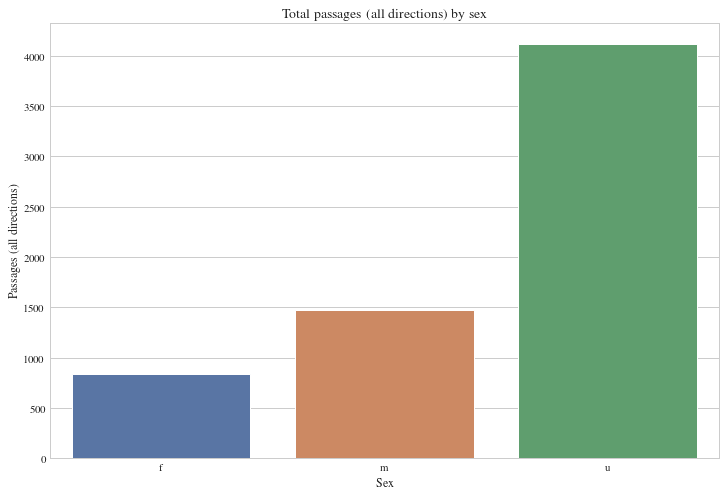

In [118]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='sex', 
            y='passage', 
            data=sex_all,
            ax=ax)
ax.set_title('Total passages (all directions) by sex', fontsize=14)
ax.set_xlabel('Sex')
ax.set_ylabel('Passages (all directions)')

### Ganska ointressanta plots, kan likagärna skrivas i text..

In [119]:
sex_summed = sex_all['passage'].sum()
sex_m = sex_all[sex_all.sex == 'm']['passage'].iloc[0]
sex_f = sex_all[sex_all.sex == 'f']['passage'].iloc[0]
sex_u = sex_all[sex_all.sex == 'u']['passage'].iloc[0]

print('percentage male: {:.3f}%'.format(100 * sex_m / sex_summed))
print('percentage female: {:.3f}%'.format(100 *sex_f / sex_summed))
print('percentage unknown: {:.3f}%'.format(100 *sex_u / sex_summed))

percentage male: 22.951%
percentage female: 13.046%
percentage unknown: 64.002%


In [120]:
df_only_true.loc[:, 'sex'] = df_only_true['sex'].str.lower()
df_only_true.loc[df_only_true.sex == 'u ', 'sex'] = 'u'

In [121]:
sex_true = df_only_true.groupby('sex').sum().reset_index()

Text(0, 0.5, 'Passages (in/out)')

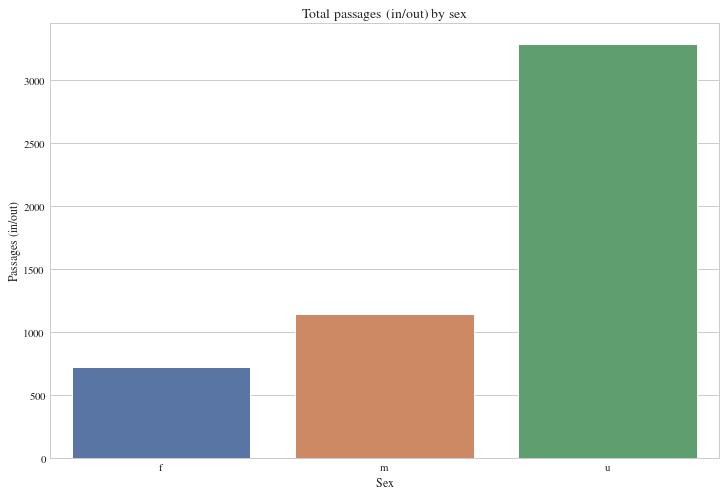

In [122]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(x='sex', 
            y='passage', 
            data=sex_true,
            ax=ax)
ax.set_title('Total passages (in/out) by sex', fontsize=14)
ax.set_xlabel('Sex')
ax.set_ylabel('Passages (in/out)')

### Samma här, bättre att bara skriva detta i en mening i texten:

In [123]:
sex_summed = sex_true['passage'].sum()
sex_m = sex_true[sex_true.sex == 'm']['passage'].iloc[0]
sex_f = sex_true[sex_true.sex == 'f']['passage'].iloc[0]
sex_u = sex_true[sex_true.sex == 'u']['passage'].iloc[0]

print('percentage male: {:.3f}%'.format(100 *sex_m / sex_summed))
print('percentage female: {:.3f}%'.format(100 *sex_f / sex_summed))
print('percentage unknown: {:.3f}%'.format(100 *sex_u / sex_summed))

percentage male: 22.229%
percentage female: 14.109%
percentage unknown: 63.663%


#### Out of all total number of passages, Passage (1/0/*) = 1, done by single individuals, Group size = 1, how many percent are male, female or unknown?

In [124]:
df_drop.sex.unique()

array([nan, 'u', 'm', 'f'], dtype=object)

In [125]:
valid_sex = ['u', 'm', 'f']

In [126]:
all_sex = df_drop[(df_drop.passage == 1) & 
                  (df_drop['group size'] == 1) &
                  (df_drop.sex.isin(valid_sex))]
male = all_sex[all_sex.sex == 'm']
female = all_sex[all_sex.sex == 'f']
unk = all_sex[all_sex.sex == 'u']

In [127]:
print('percentage male {:.3f}%'
      .format(100 *len(male.index) / len(all_sex.index)))

print('percentage female {:.3f}%'
      .format(100 *len(female.index) / len(all_sex.index)))

print('percentage unknown {:.3f}%'
      .format(100 *len(unk.index) / len(all_sex.index)))

percentage male 63.543%
percentage female 1.618%
percentage unknown 34.838%


####  (111-114) "Out of all total number of passages, Passage (1/0/*) = 1, done by single individuals, Group size = 1, how many percent are male, female or unknown?" - göra om denna analysen men för bara passages in/out?

In [128]:
all_sex = df_drop[(df_drop.passage == 1) &
                  (df_drop.direction.isin(['in', 'out'])) &
                  (df_drop['group size'] == 1) &
                  (df_drop.sex.isin(valid_sex))]
male = all_sex[all_sex.sex == 'm']
female = all_sex[all_sex.sex == 'f']
unk = all_sex[all_sex.sex == 'u']

In [129]:
print('percentage male {:.3f}%'
      .format(100 *len(male.index) / len(all_sex.index)))

print('percentage female {:.3f}%'
      .format(100 *len(female.index) / len(all_sex.index)))

print('percentage unknown {:.3f}%'
      .format(100 *len(unk.index) / len(all_sex.index)))

percentage male 68.085%
percentage female 1.120%
percentage unknown 30.795%


### Passager per månfas
Moon phase är indelad i 1-8 där fullmåne är 5. Finns förklarat under ”methods” i arbetet.

#### Total number of passages taking place at night sorted per moon phase
Dvs. Av totala antalet passager i alla riktningar och som sker mellan kl 19:00 och 07:00, hur är
dessa fördelade per månfas?


In [130]:
moon = df_drop[(df_drop.passage == 1) & ((df_drop.hour >= 19) | (df_drop.hour <= 6))]
moon = moon.groupby('moon phase').sum().reset_index()

Text(0, 0.5, 'Passages (any direction)')

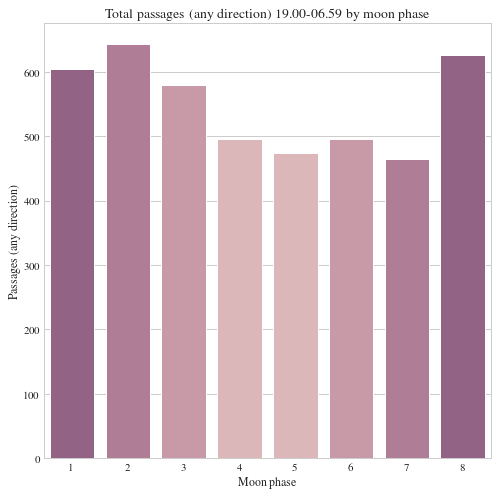

In [131]:
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)[:-3]
sns.barplot(x='moon phase', 
            y='passage', 
            data=moon,
            palette=[cp[4],cp[3], cp[2], cp[1], cp[1], cp[2], cp[3],cp[4]],
            ax=ax)
ax.set_title('Total passages (any direction) 19.00-06.59 by moon phase', fontsize=14)
ax.set_xlabel('Moon phase')
ax.set_ylabel('Passages (any direction)')

Text(0, 0.5, 'Passages (any direction)')

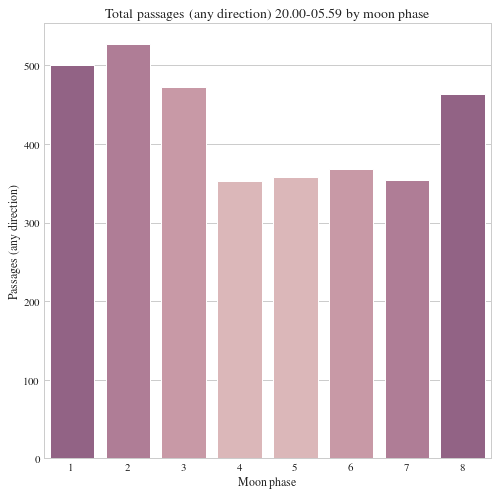

In [132]:
moon2 = df_drop[(df_drop.passage == 1) & ((df_drop.hour >= 20) | (df_drop.hour <= 5))]
moon2 = moon2.groupby('moon phase').sum().reset_index()
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)[:-3]
sns.barplot(x='moon phase', 
            y='passage', 
            data=moon2,
            palette=[cp[4],cp[3], cp[2], cp[1], cp[1], cp[2], cp[3],cp[4]],
            ax=ax)
ax.set_title('Total passages (any direction) 20.00-05.59 by moon phase', fontsize=14)
ax.set_xlabel('Moon phase')
ax.set_ylabel('Passages (any direction)')

#### Total number of true passages taking place at night sorted per moon phase
Dvs. Av antalet passager som sker in resp out och som sker mellan kl 19:00 och 07:00, hur är
dessa fördelade per månfas?


Text(0, 0.5, 'Passages (in/out)')

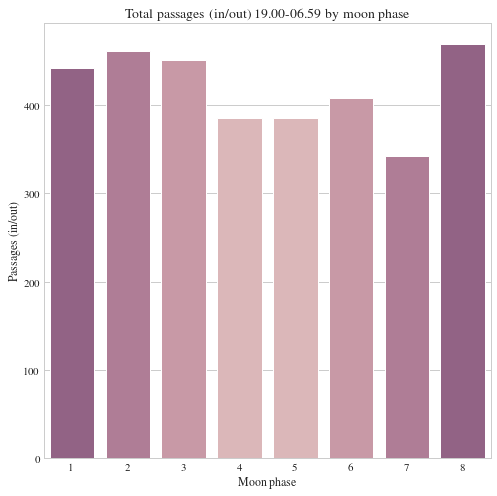

In [133]:
moon_true = df_only_true[(df_only_true.passage == 1) & ((df_only_true.hour >= 19) | (df_only_true.hour <= 6))]
moon_true = moon_true.groupby('moon phase').sum().reset_index()
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)[:-3]
sns.barplot(x='moon phase', 
            y='passage', 
            data=moon_true,
            palette=[cp[4],cp[3], cp[2], cp[1], cp[1], cp[2], cp[3],cp[4]],
            ax=ax)
ax.set_title('Total passages (in/out) 19.00-06.59 by moon phase', fontsize=14)
ax.set_xlabel('Moon phase')
ax.set_ylabel('Passages (in/out)')

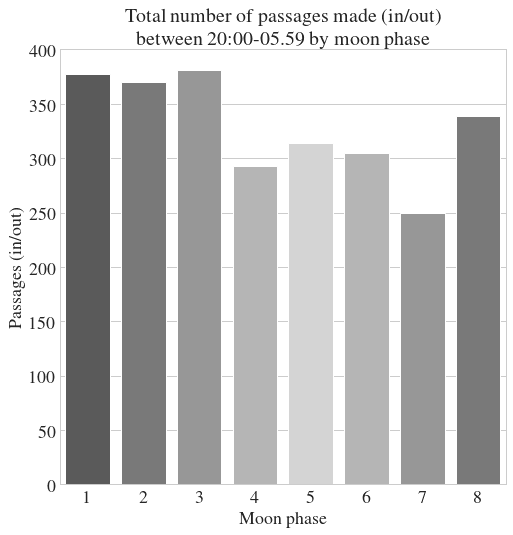

In [412]:
moon_true2 = df_only_true[(df_only_true.passage == 1) & ((df_only_true.hour >= 20) | (df_only_true.hour <= 5))]
moon_true2 = moon_true2.groupby('moon phase').sum().reset_index()
fig, ax = plt.subplots(1, figsize=(8,8))
#cp = sns.cubehelix_palette(9)[:-3]
cp = sns.light_palette("black", 9)
sns.barplot(x='moon phase', 
            y='passage', 
            data=moon_true2,
            palette=[cp[5],cp[4], cp[3], cp[2], cp[1], cp[2], cp[3],cp[4]],
            ax=ax)
ax.set_title('Total number of passages made (in/out) \n between 20:00-05.59 by moon phase', fontsize=20)
ax.set_xlabel('Moon phase', fontsize=18)
ax.set_ylabel('Passages (in/out)', fontsize=18)
labels = ax.xaxis.get_majorticklabels() 
ax.set_xticklabels(labels, rotation=0, ha='center', minor=False, fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

#### - Övrigt
Ökade användandet av korridor 1 och 2 efter 25 april 2017 jämför med tidigare? (Då stängde
man korridor 3 permanent.)

### T-test som inte förutsätter samma varians (Welch's t-test):

Vi kan jämföra skillnader i mean mellan de två serierna med data för dagliga passager före och efter datumen för varje korridor. T-test som används förklaras här: [scipy dokumentation för t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

Eftersom vi nog inte inte bör anta att variansen i samples är lika (de har olika storlek) så kan vi använda Welch's t-test också. Beskrivs i wikipedia som:

${\displaystyle t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{\bar {\Delta }}}}}$

where

${\displaystyle s_{\bar {\Delta }}={\sqrt {{\frac {s_{1}^{2}}{n_{1}}}+{\frac {s_{2}^{2}}{n_{2}}}}}} $

$ {\bar {X}}_{1} $ och $ {\bar {X}}_{2} $ are the means for samples 1 and 2.

Here $s_{i}^{2}$ is the unbiased estimator of the variance of each of the two samples with $n_{i}$ = number of participants in group i (1 or 2).

Uppskattning av varians och allt annat beskrivs här: https://en.wikipedia.org/wiki/Student%27s_t-test

In [135]:
after = df_drop[df_drop.date >= '2017-04-25']
before = df_drop[df_drop.date < '2017-04-25']

after_1 = after[after.corridor == 1]
after_2 = after[after.corridor == 2]

before_1 = before[before.corridor == 1]
before_2 = before[before.corridor == 2]

In [136]:
def group_and_sum(input_df):
    res_df = input_df.groupby('date').sum().reset_index()
    res_df['year'] = res_df['date'].apply(lambda t: t.strftime('%Y'))
    res_df['month'] = res_df['date'].apply(lambda t: t.strftime('%m'))
    res_df['year_month'] = res_df['date'].apply(lambda t: t.strftime('%Y-%m'))
    return res_df

In [137]:
after_1 = group_and_sum(after_1)
after_2 = group_and_sum(after_2)

before_1 = group_and_sum(before_1)
before_2 = group_and_sum(before_2)

In [138]:
print(before_1.date.min())
print(before_1.date.max(), '\n')

print(before_2.date.min())
print(before_2.date.max())

2016-12-26 00:00:00
2017-04-23 00:00:00 

2015-06-02 00:00:00
2017-04-24 00:00:00


Ganska få datum i korridor 1, endast från 2017-01-02 till 2017-04-23...

In [139]:
print(after_1.date.min())
print(after_1.date.max(), '\n')

print(after_2.date.min())
print(after_2.date.max())

2017-04-26 00:00:00
2018-05-27 00:00:00 

2017-04-25 00:00:00
2018-05-18 00:00:00


The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

In [140]:
ttest_ind(before_1.passage, after_1.passage, equal_var=False)

Ttest_indResult(statistic=-2.938411841193937, pvalue=0.00394858997489697)

$ pvalue = 0.00013 < 0.05 $ d.v.s vi kan förkasta nollhypotesen att våra samples från korridor 1 har samma väntvärde (mean)

In [141]:
ttest_ind(before_2.passage, after_2.passage, equal_var=False)

Ttest_indResult(statistic=-2.928782038384555, pvalue=0.0035868464667852544)

$ pvalue = 0.004 < 0.05 $ d.v.s vi kan förkasta nollhypotesen att våra samples från korridor 2 har samma väntvärde (mean)

I båda fallen verkar alltså stängningen av korridor 3 ha påverkat resultaten, men det är som sagt väldigt få samples från korridor 1 före 2017-04-23, det verkar som korridor 1 endast kom till 2017-01-02 jämfört med korridor 2 som har datum fr.o.m 2015-06-02?

### T-test där vi förutsätter samma varians (student's t-test):

In [142]:
ttest_ind(before_1.passage, after_1.passage, equal_var=True)

Ttest_indResult(statistic=-1.9191456711680643, pvalue=0.056877516586537516)

In [143]:
ttest_ind(before_2.passage, after_2.passage, equal_var=True)

Ttest_indResult(statistic=-3.0345411865622474, pvalue=0.0025108906292630674)

Även här är vi säkra på att vi kan förkasta nollhypotesen att stängningen av korridor 3 in påverkade (eller snarare att de två uppskattade medelvärdena för distributionerna är jämna, vilket är vad vi faktiskt testar):

korridor 1 $ pvalue=0.029 < 0.05 $

korridor 2 $ pvalue=0.003 < 0.05 $

### T-test av passager mellan grupperna i `sex`

Det vi gör här är att dela upp datan efter kön och summera passagerna för varje dag. Vi undersöker sedan om distributionerna är skiljda med avseende på medelvärde, både med och utan förutsättningen att de har lika varians.

In [144]:
sex_groups = [
    ('male', df_drop[df_drop.sex == 'm'].groupby('date').sum().reset_index()),
    ('female', df_drop[df_drop.sex == 'f'].groupby('date').sum().reset_index()),
    ('unknown', df_drop[df_drop.sex == 'u'].groupby('date').sum().reset_index())
]

In [145]:
def run_ttests(groups):
    for i, group_a in enumerate(groups):
        for group_b in groups[i+1:]:
            print('-'*25)
            print('T-test between {} and {} ..'.format(group_a[0], group_b[0]))
            res_eqvar = ttest_ind(group_a[1].passage, group_b[1].passage, equal_var=True)
            res_not_eqvar = ttest_ind(group_a[1].passage, group_b[1].passage, equal_var=False)
            print('Student t-test p-value: {}'.format(res_eqvar.pvalue))
            print('Welch t-test p-value: {}'.format(res_eqvar.pvalue))
            print('-'*25)
            print('\n')

In [146]:
run_ttests(sex_groups)

-------------------------
T-test between male and female ..
Student t-test p-value: 0.028804573337424227
Welch t-test p-value: 0.028804573337424227
-------------------------


-------------------------
T-test between male and unknown ..
Student t-test p-value: 1.4932116824995184e-27
Welch t-test p-value: 1.4932116824995184e-27
-------------------------


-------------------------
T-test between female and unknown ..
Student t-test p-value: 7.399152695021994e-12
Welch t-test p-value: 7.399152695021994e-12
-------------------------




Notationen `1.9021434882038964e-26` betyder $~ 1.90 * 10^{-26}$, väldigt små värden dvs. Signifikanta skillnader i passager mellan könen.

### T-test av "true" passager mellan grupperna i `sex`

In [147]:
sex_groups_true = [
    ('male', df_only_true[df_only_true.sex == 'm'].groupby('date').sum().reset_index()),
    ('female', df_only_true[df_only_true.sex == 'f'].groupby('date').sum().reset_index()),
    ('unknown', df_only_true[df_only_true.sex == 'u'].groupby('date').sum().reset_index())
]

In [148]:
run_ttests(sex_groups_true)

-------------------------
T-test between male and female ..
Student t-test p-value: 3.225197214565106e-05
Welch t-test p-value: 3.225197214565106e-05
-------------------------


-------------------------
T-test between male and unknown ..
Student t-test p-value: 1.6635986241065974e-31
Welch t-test p-value: 1.6635986241065974e-31
-------------------------


-------------------------
T-test between female and unknown ..
Student t-test p-value: 3.747973672717367e-11
Welch t-test p-value: 3.747973672717367e-11
-------------------------




Väldigt små värden $ < 0.05 $ här också, signifikanta skillnader för true passages mellan kön.

### T-test av passager mellan grupperna i moon phases

Blir väldigt många värden att testa mellan alla moon phases (7+6+5+4...). Vi kan stoppa resultaten av testerna i en ny tabell, så kan du presentera dem så om du vill. Om du vill ha det som ett excel ark eller .csv fil kan det exporteras också.

In [149]:
moon = df_drop[(df_drop.passage == 1) & ((df_drop.hour >= 19) | (df_drop.hour <= 6))]

In [150]:
sorted(moon['moon phase'].unique())

[1, 2, 3, 4, 5, 6, 7, 8]

In [151]:
moon_groups = [
    (moon_phase, moon[moon['moon phase'] == moon_phase].groupby('date').sum().reset_index())\
    for moon_phase in sorted(moon['moon phase'].unique())
]

In [152]:
def get_moon_phase_ttests(groups):
    res = []
    for i, group_a in enumerate(groups):
        target_group = group_a[0]
        for group_b in groups[i+1:]:
            query_group = group_b[0]
            res_eqvar = ttest_ind(group_a[1].passage, group_b[1].passage, equal_var=True)
            res_not_eqvar = ttest_ind(group_a[1].passage, group_b[1].passage, equal_var=False)
            res.append([target_group, query_group, res_eqvar.pvalue, res_not_eqvar.pvalue])
            
    return pd.DataFrame(data=res, columns=['moon_phase_a', 'moon_phase_b', 
                                           'student_ttest_pval', 'welch_ttest_pval'])

In [153]:
moon_ttests = get_moon_phase_ttests(moon_groups)

### Tabellen nedan visar alltså t-test mellan kolumnerna `moon_phase_a` och `moon_phase_b`

In [154]:
moon_ttests

,moon_phase_a,moon_phase_b,student_ttest_pval,welch_ttest_pval
0,1,2,0.756564,0.756475
1,1,3,0.547016,0.547553
2,1,4,0.368403,0.366754
3,1,5,0.573672,0.573983
4,1,6,0.527962,0.527317
5,1,7,0.268369,0.267996
6,1,8,0.607741,0.611026
7,2,3,0.365566,0.366810
8,2,4,0.233783,0.230921
9,2,5,0.400487,0.398562


Är det något av ttesten som visar på signifikant skillnad $(p < 0.05)$ för testen? 

In [155]:
moon_ttests[moon_ttests.student_ttest_pval < 0.05]

,moon_phase_a,moon_phase_b,student_ttest_pval,welch_ttest_pval


In [156]:
moon_ttests[moon_ttests.welch_ttest_pval < 0.05]

,moon_phase_a,moon_phase_b,student_ttest_pval,welch_ttest_pval


Två tomma tabeller, så nej! Inga signifikanta skillnader i passager mellan olika moon phases

Lägst p-värde fick vi här:

In [157]:
# för student's t-test
moon_ttests[moon_ttests.student_ttest_pval == moon_ttests.student_ttest_pval.min()]

,moon_phase_a,moon_phase_b,student_ttest_pval,welch_ttest_pval
11,2,7,0.1682,0.166801


In [158]:
# för welch's t-test
moon_ttests[moon_ttests.welch_ttest_pval == moon_ttests.welch_ttest_pval.min()]

,moon_phase_a,moon_phase_b,student_ttest_pval,welch_ttest_pval
11,2,7,0.1682,0.166801


## Nya analyser 2019-06

Passages per hour:
Lägg till diagram för mean passages per hour of day all directions samt "true" directions (så att SE och p-värde fås).

In [159]:
def add_missing_hours(summed_df):
    """
    Adds 0 passages for all missing hours of each day
    Only input df with columns `date`, `hour` and summed `passage`
    """
    to_add = []
    for some_date in summed_df.date.unique():
        hours_in_date = summed_df[summed_df.date == some_date].hour.values
        hours_to_add = [x for x in range(0,24) if x not in hours_in_date]
        for hour in hours_to_add:
            to_add.append([some_date, hour, 0])
    
    summed_df = summed_df.append(pd.DataFrame(data=to_add, columns=['date', 'hour', 'passage']))    
    summed_df = summed_df.sort_values(by=['date', 'hour'])

    return summed_df

In [160]:
hour_grouped = df_drop.groupby(['date', 'hour']).sum().reset_index()

In [161]:
hour_df = add_missing_hours(hour_grouped[['date', 'hour', 'passage']])

/home/max/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Passages (any direction)')

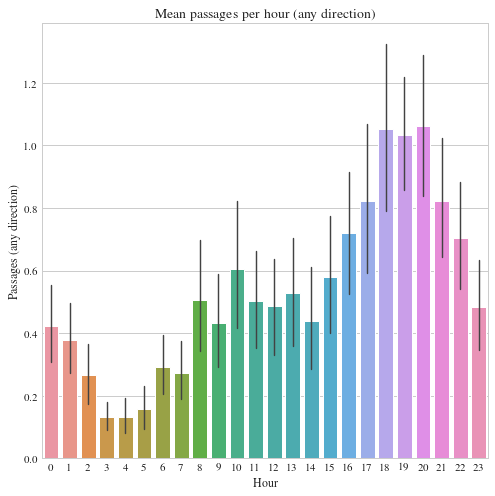

In [162]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.barplot(x='hour', 
            y='passage', 
            data=hour_df,
            #palette=p,
            ax=ax)
ax.set_title('Mean passages per hour (any direction)', fontsize=14)
ax.set_xlabel('Hour')
ax.set_ylabel('Passages (any direction)')

In [163]:
true_dirs = df_drop[df_drop.direction.isin(['in', 'out'])]
true_hour_grouped = true_dirs.groupby(['date', 'hour']).sum().reset_index()

In [164]:
hour_true_df = add_missing_hours(true_hour_grouped[['date', 'hour', 'passage']])

Text(0, 0.5, 'Passages (in/out)')

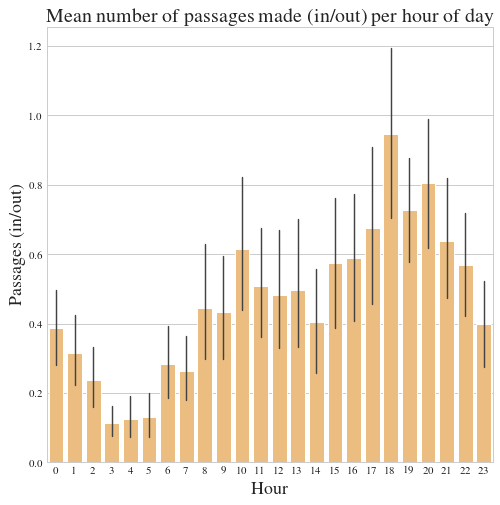

In [375]:
fig, ax = plt.subplots(1, figsize=(8,8))
sns.barplot(x='hour', 
            y='passage', 
            data=hour_true_df,
            palette=[palette[6]],
            ax=ax)
ax.set_title('Mean number of passages made (in/out) per hour of day', fontsize=20)
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('Passages (in/out)', fontsize=18)

### Lägg till diagram för percentage of passages done per group size, all directions samt "true"

Denna plot finns redan lite längre upp i notebooken och datan finns i g_size och g_size_true

### All directions

In [166]:
def SE_percentage(p, n):
    return (p*(100-p) / n) ** 0.5

In [167]:
g_size['gs_percentage'] = g_size['passage']\
.apply(lambda x: '{:.2f}%'.format(x / g_size['passage'].sum() * 100))

g_size['SE_percentage'] = g_size['gs_percentage']\
.apply(lambda x: SE_percentage(float(x[:-1]), g_size['passage'].sum()))

In [168]:
g_size[['group size', 'passage', 'gs_percentage', 'SE_percentage']]

,group size,passage,gs_percentage,SE_percentage
0,1,1598,16.73%,0.381896
1,2,693,7.26%,0.265494
2,3,523,5.48%,0.232865
3,4,489,5.12%,0.225515
4,5,555,5.81%,0.239355
5,6,608,6.37%,0.249879
6,7,567,5.94%,0.241851
7,8,688,7.20%,0.264480
8,9,549,5.75%,0.238192
9,10,400,4.19%,0.205005


### In/Out directions

In [169]:
sum_pass_true = g_size_true.passage.sum()

In [170]:
g_size_true['gs_percentage'] = g_size_true['passage']\
.apply(lambda x: '{:.2f}%'.format(x / g_size_true.passage.sum() * 100))

g_size_true['SE_percentage'] = g_size_true['gs_percentage']\
.apply(lambda x: SE_percentage(float(x[:-1]), g_size_true['passage'].sum()))

In [171]:
g_size_true[['group size', 'passage', 'gs_percentage', 'SE_percentage']]

,group size,passage,gs_percentage,SE_percentage
0,1,1247,15.80%,0.410626
1,2,515,6.53%,0.278134
2,3,377,4.78%,0.240181
3,4,345,4.37%,0.230144
4,5,431,5.46%,0.255779
5,6,474,6.01%,0.267571
6,7,473,5.99%,0.267154
7,8,533,6.76%,0.282642
8,9,459,5.82%,0.263574
9,10,352,4.46%,0.232392


##### "Lägg till diagram för mean passages per moon phase (fortf bara nattetid) för all directions samt för "true" directions för att få SE och p-värden till datan. 


#### Även göra mean passages som ovan men för bara de passager som görs under dygnets mörka timmar. Dvs mellan kl 20:00-05:59."

Jag lägger nu till moon phase 1-8 för alla datum med passage = 0 om det inte gjordes några passages för vid en moon phase i datumet.

In [172]:
mp_sum = df_drop[(df_drop.hour >= 19) | (df_drop.hour <= 6)].groupby(['date', 'moon phase']).sum().reset_index()

In [173]:
def add_missing_mp(summed_df):
    """
    Adds 0 passages for all missing moon phases of each day
    Only input df with columns `date`, `moon phase` and summed `passage`
    """
    to_add = []
    for some_date in summed_df.date.unique():
        mp_in_date = summed_df[summed_df.date == some_date]['moon phase'].values
        mp_to_add = [x for x in range(1,9) if x not in mp_in_date]
        for mp in mp_to_add:
            to_add.append([some_date, mp, 0])
    
    summed_df = summed_df.append(pd.DataFrame(data=to_add, columns=['date', 'moon phase', 'passage']))    
    summed_df = summed_df.sort_values(by=['date', 'moon phase'])

    return summed_df

In [174]:
mp_sum[['date', 'moon phase', 'passage']].head()

,date,moon phase,passage
0,2015-06-02,5,5
1,2015-06-04,6,1
2,2015-06-06,6,6
3,2015-06-08,7,1
4,2015-06-10,7,4


In [175]:
mp_sum = add_missing_mp(mp_sum[['date', 'moon phase', 'passage']])

In [176]:
mp_sum.head()

,date,moon phase,passage
0,2015-06-02,1,0
1,2015-06-02,2,0
2,2015-06-02,3,0
3,2015-06-02,4,0
0,2015-06-02,5,5


## Tiden 19.00-06.59 här

Text(0, 0.5, 'Passages (any direction)')

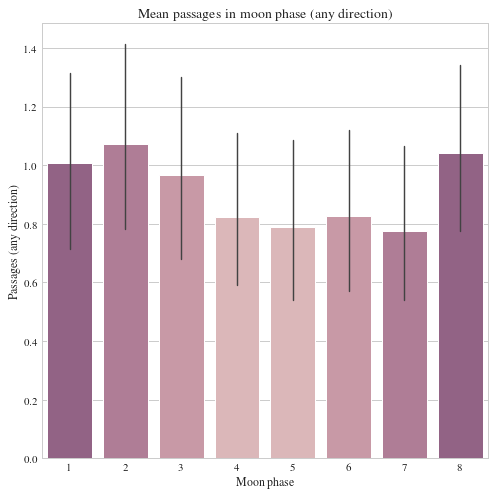

In [177]:
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)[:-3]
sns.barplot(x='moon phase', 
            y='passage', 
            data=mp_sum,
            palette=[cp[4],cp[3], cp[2], cp[1], cp[1], cp[2], cp[3],cp[4]],
            ax=ax)
ax.set_title('Mean passages in moon phase (any direction)', fontsize=14)
ax.set_xlabel('Moon phase')
ax.set_ylabel('Passages (any direction)')

## Tiden 20.00-05.59 här

Text(0, 0.5, 'Passages (any direction)')

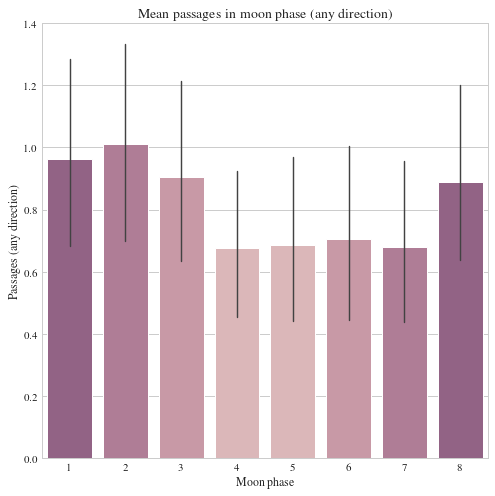

In [178]:
mp_sum = df_drop[(df_drop.hour >= 20) | (df_drop.hour <= 5)].groupby(['date', 'moon phase']).sum().reset_index()
mp_sum = add_missing_mp(mp_sum[['date', 'moon phase', 'passage']])
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)[:-3]
sns.barplot(x='moon phase', 
            y='passage', 
            data=mp_sum,
            palette=[cp[4],cp[3], cp[2], cp[1], cp[1], cp[2], cp[3],cp[4]],
            ax=ax)
ax.set_title('Mean passages in moon phase (any direction)', fontsize=14)
ax.set_xlabel('Moon phase')
ax.set_ylabel('Passages (any direction)')

### Samma för true dirs

In [179]:
mp_sum_true = true_dirs[(true_dirs.hour >= 19) | (true_dirs.hour <= 6)].groupby(['date', 'moon phase']).sum().reset_index()

In [180]:
mp_sum_true[['date', 'moon phase', 'passage']].head()

,date,moon phase,passage
0,2015-06-02,5,1
1,2015-06-10,7,2
2,2015-06-11,8,4
3,2015-06-12,8,14
4,2015-06-13,8,6


In [181]:
mp_sum_true = add_missing_mp(mp_sum_true[['date', 'moon phase', 'passage']])

In [182]:
mp_sum_true.head()

,date,moon phase,passage
0,2015-06-02,1,0
1,2015-06-02,2,0
2,2015-06-02,3,0
3,2015-06-02,4,0
0,2015-06-02,5,1


## Tiden 19.00-06.59 här (true dirs)

Text(0, 0.5, 'Passages (in/out)')

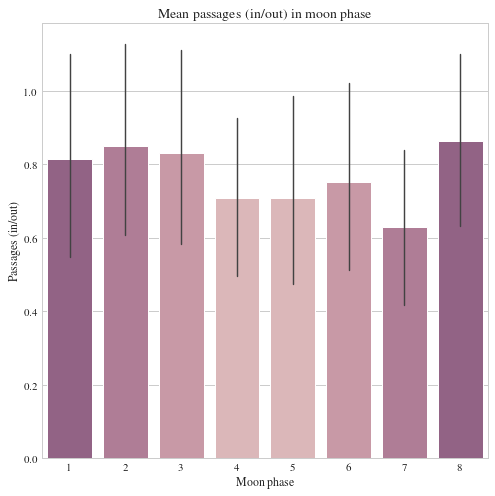

In [183]:
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)[:-3]
sns.barplot(x='moon phase', 
            y='passage', 
            data=mp_sum_true,
            palette=[cp[4],cp[3], cp[2], cp[1], cp[1], cp[2], cp[3],cp[4]],
            ax=ax)
ax.set_title('Mean passages (in/out) in moon phase', fontsize=14)
ax.set_xlabel('Moon phase')
ax.set_ylabel('Passages (in/out)')

## Tiden 20.00-05.59 här (true dirs)

Text(0, 0.5, 'Passages (in/out)')

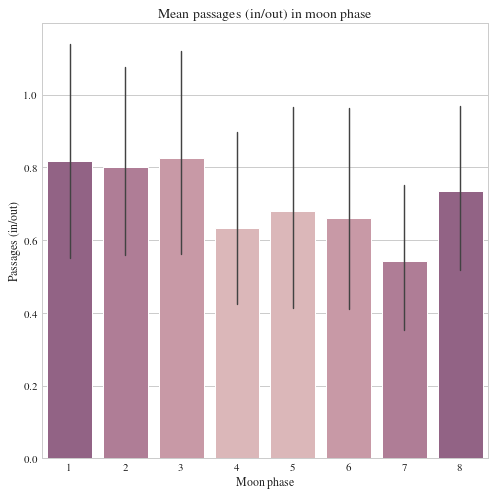

In [184]:
mp_sum_true = true_dirs[(true_dirs.hour >= 20) | (true_dirs.hour <= 5)].groupby(['date', 'moon phase']).sum().reset_index()
mp_sum_true = add_missing_mp(mp_sum_true[['date', 'moon phase', 'passage']])
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)[:-3]
sns.barplot(x='moon phase', 
            y='passage', 
            data=mp_sum_true,
            palette=[cp[4],cp[3], cp[2], cp[1], cp[1], cp[2], cp[3],cp[4]],
            ax=ax)
ax.set_title('Mean passages (in/out) in moon phase', fontsize=14)
ax.set_xlabel('Moon phase')
ax.set_ylabel('Passages (in/out)')

### Lägg till diagram av vad detta visar men bara indelat på 3 faser/nivåer av månljus: 0-33%, 34-66%, 67-100% luminocity. Dvs gruppera utifrån luminocity i rådatan, inte moon phases.

In [185]:
def categorize_lumin(x):
    if x <= 0.33:
        return '0-33\%'
    if x > 0.33 and x <= 0.66:
        return '34-66\%'
    return '67-100\%'

In [186]:
df_drop.head(1)

,date,hour,corridor,camera,sex,direction,direction_numerical,group size,passage,luminosity,moon phase,year_month,month_day,month,day
1,2015-06-29,9,2,a,NaN,unknown,NaN,1,1,0.939784,4,2015-06,06-29,06,29


In [187]:
df_drop['lumin_cat'] = df_drop['luminosity'].apply(lambda x: categorize_lumin(x))

/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [188]:
df_drop.head(1)

,date,hour,corridor,camera,sex,direction,direction_numerical,group size,passage,luminosity,moon phase,year_month,month_day,month,day,lumin_cat
1,2015-06-29,9,2,a,NaN,unknown,NaN,1,1,0.939784,4,2015-06,06-29,06,29,67-100\%


Summerat över luminosity kategorierna:

In [189]:
lum_sum = df_drop[(df_drop.hour >= 20) | (df_drop.hour <= 5)]\
.groupby('lumin_cat').sum().reset_index()[['lumin_cat', 'passage']]

In [190]:
lum_sum

,lumin_cat,passage
0,0-33\%,1553
1,34-66\%,715
2,67-100\%,1128


Text(0, 0.5, 'Passages (any direction)')

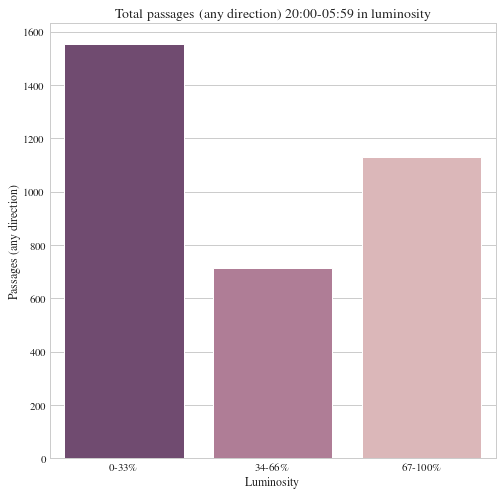

In [191]:
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)
sns.barplot(x='lumin_cat', 
            y='passage', 
            data=lum_sum,
            palette=[cp[5],cp[3], cp[1]],
            ax=ax)
ax.set_title('Total passages (any direction) 20:00-05:59 in luminosity', fontsize=14)
ax.set_xlabel('Luminosity')
ax.set_ylabel('Passages (any direction)')

In [192]:
lum_sum2 = df_drop[
    ((df_drop.direction == 'in') | 
     (df_drop.direction == 'out')) &
    (df_drop.hour >= 20) | (df_drop.hour <= 5)
]\
.groupby('lumin_cat').sum().reset_index()[['lumin_cat', 'passage']]

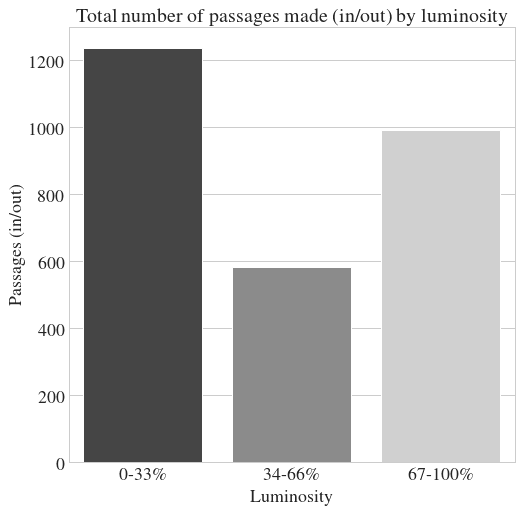

In [414]:
fig, ax = plt.subplots(1, figsize=(8,8))
#cp = sns.cubehelix_palette(8)
cp = sns.light_palette('black', 8)
sns.barplot(x='lumin_cat', 
            y='passage', 
            data=lum_sum2,
            palette=[cp[5],cp[3], cp[1]],
            ax=ax)
ax.set_title('Total number of passages made (in/out) by luminosity', fontsize=20)
ax.set_xlabel('Luminosity', fontsize=18)
ax.set_ylabel('Passages (in/out)', fontsize=18)
labels = ax.xaxis.get_majorticklabels() 
ax.set_xticklabels(labels, rotation=0, ha='center', minor=False, fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

Antar att du vill ha CI för dessa också, men då är problemet igen att vi saknar data. Vi får summera och lägga till saknad data..

In [194]:
lum_date_sum = df_drop.groupby(['date', 'lumin_cat']).sum().reset_index()[['date', 'lumin_cat', 'passage']]

In [195]:
lum_date_sum.head()

,date,lumin_cat,passage
0,2015-06-02,67-100\%,6
1,2015-06-03,67-100\%,3
2,2015-06-04,67-100\%,11
3,2015-06-06,67-100\%,6
4,2015-06-08,34-66\%,1


In [196]:
def add_missing_lum(summed_df):
    """
    Adds 0 passages for all missing luminosity categories of each day
    Only input df with columns `date`, `lumin_cat` and summed `passage`
    """
    to_add = []
    for some_date in summed_df.date.unique():
        lum_in_date = summed_df[summed_df.date == some_date]['lumin_cat'].values
        lum_to_add = [x for x in ['0-33\%', '34-66\%', '67-100\%'] if x not in lum_in_date]
        for lum in lum_to_add:
            to_add.append([some_date, lum, 0])
    
    summed_df = summed_df.append(pd.DataFrame(data=to_add, columns=['date', 'lumin_cat', 'passage']))    
    summed_df = summed_df.sort_values(by=['date', 'lumin_cat'])

    return summed_df

In [197]:
lum_date_sum = add_missing_lum(lum_date_sum)

In [198]:
lum_date_sum.head()

,date,lumin_cat,passage
0,2015-06-02,0-33\%,0
1,2015-06-02,34-66\%,0
0,2015-06-02,67-100\%,6
2,2015-06-03,0-33\%,0
3,2015-06-03,34-66\%,0


Text(0, 0.5, 'Passages (any direction)')

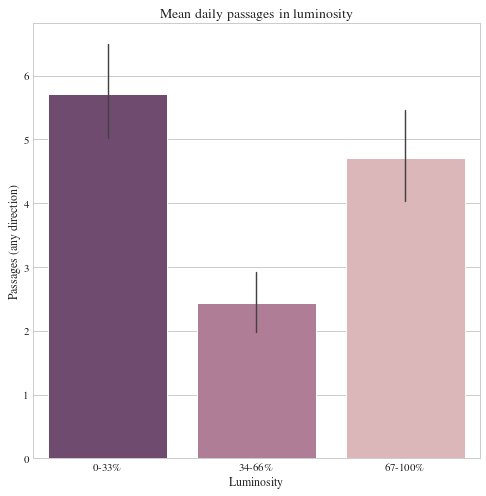

In [199]:
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)
sns.barplot(x='lumin_cat', 
            y='passage', 
            data=lum_date_sum,
            palette=[cp[5],cp[3], cp[1]],
            ax=ax)
ax.set_title('Mean daily passages in luminosity', fontsize=14)
ax.set_xlabel('Luminosity')
ax.set_ylabel('Passages (any direction)')

### Same for "true" dir

In [200]:
true_lum_date_sum = df_drop[df.direction.isin(['in', 'out'])].groupby(['date', 'lumin_cat']).sum().reset_index()[['date', 'lumin_cat', 'passage']]

/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [201]:
true_lum_date_sum.head()

,date,lumin_cat,passage
0,2015-06-02,67-100\%,2
1,2015-06-03,67-100\%,1
2,2015-06-04,67-100\%,10
3,2015-06-10,34-66\%,3
4,2015-06-11,0-33\%,25


In [202]:
true_lum_date_sum = add_missing_lum(true_lum_date_sum)

In [203]:
true_lum_date_sum.head()

,date,lumin_cat,passage
0,2015-06-02,0-33\%,0
1,2015-06-02,34-66\%,0
0,2015-06-02,67-100\%,2
2,2015-06-03,0-33\%,0
3,2015-06-03,34-66\%,0


Text(0, 0.5, 'Passages (in/out)')

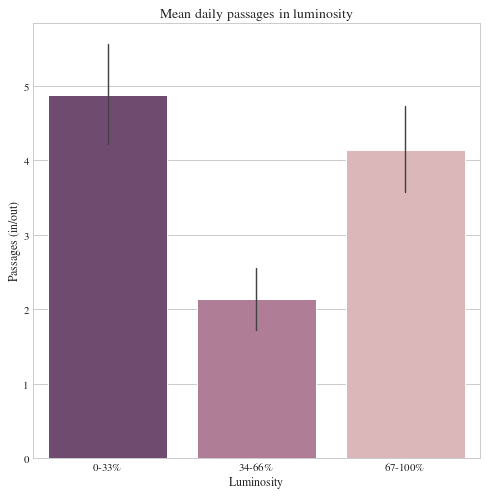

In [204]:
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)
sns.barplot(x='lumin_cat', 
            y='passage', 
            data=true_lum_date_sum,
            palette=[cp[5],cp[3], cp[1]],
            ax=ax)
ax.set_title('Mean daily passages in luminosity', fontsize=14)
ax.set_xlabel('Luminosity')
ax.set_ylabel('Passages (in/out)')

##### "Stängning av korridor 3:
Korridor 3 stängdes den 25e april 2017 och har varit stängd sedan dess.
Ses någon skillnad i mean number of passages per day för corridor 1 och för corridor 2 (analyserade var och en för sig och illustrerade i diagram) före och efter datumet för stängning?"

In [319]:
before = df_drop[df_drop.date < '2017-04-21']
after = df_drop[df_drop.date >= '2017-04-21']

In [320]:
before.date.max()

Timestamp('2017-04-20 00:00:00')

In [321]:
after.date.min()

Timestamp('2017-04-22 00:00:00')

In [322]:
before_cor1 = before[before.corridor == 1].groupby('date').sum().reset_index()
before_cor1 = add_missing_dates(before_cor1[['date', 'passage']])
before_cor2 = before[before.corridor == 2].groupby('date').sum().reset_index()
before_cor2 = add_missing_dates(before_cor2[['date', 'passage']])

In [323]:
after_cor1 = after[after.corridor == 1].groupby('date').sum().reset_index()
after_cor1 = add_missing_dates(after_cor1[['date', 'passage']])
after_cor2 = after[after.corridor == 2].groupby('date').sum().reset_index()
after_cor2 = add_missing_dates(after_cor2[['date', 'passage']])

In [324]:
ttest_ind(before_cor1['passage'], after_cor1['passage'], equal_var=True)

Ttest_indResult(statistic=-1.7978828327763545, pvalue=0.07278344517112262)

Skillnader i medelvärde för korridor 1:

$  pvalue=0.058207195414347046 $ 

icke-signifikant, men väldigt nära för vanliga $p < 0.05$ gränsen

In [325]:
ttest_ind(before_cor2['passage'], after_cor2['passage'])

Ttest_indResult(statistic=-2.8298831546509176, pvalue=0.004742927908403351)

Skillnader i medelvärde för korridor 2:

$ pvalue=0.0035310090050718365 $

signifikant för $ p < 0.05 $

In [326]:
# add "dategroup" to all
before_cor1['Date'] = 'before 2017-04-21'
before_cor1['corridor'] = 1
before_cor2['Date'] = 'before 2017-04-21'
before_cor2['corridor'] = 2
after_cor1['Date'] = 'after 2017-04-21'
after_cor1['corridor'] = 1
after_cor2['Date'] = 'after 2017-04-21'
after_cor2['corridor'] = 2

In [327]:
to_plot = pd.DataFrame(columns=['date', 'Date', 'corridor', 'passage'])

In [328]:
to_plot = to_plot.append(before_cor1[['date', 'Date', 'corridor', 'passage']])
to_plot = to_plot.append(before_cor2[['date', 'Date', 'corridor', 'passage']])
to_plot = to_plot.append(after_cor1[['date', 'Date', 'corridor', 'passage']])
to_plot = to_plot.append(after_cor2[['date', 'Date', 'corridor', 'passage']])

In [329]:
to_plot.head()

,date,Date,corridor,passage
0,2016-12-26,before 2017-04-21,1,16
0,2016-12-27,before 2017-04-21,1,0
1,2016-12-28,before 2017-04-21,1,2
2,2016-12-29,before 2017-04-21,1,9
1,2016-12-30,before 2017-04-21,1,0


Text(0, 0.5, 'Passages (any direction)')

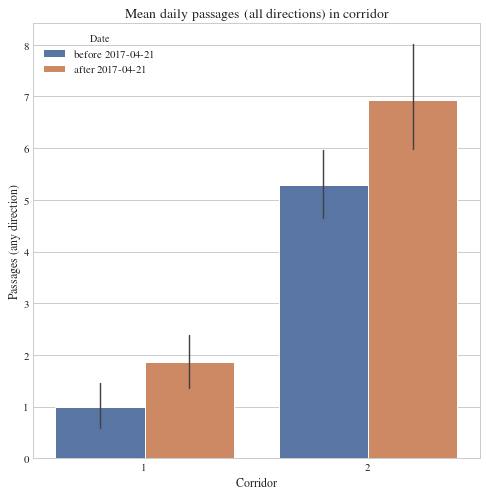

In [330]:
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.cubehelix_palette(8)
sns.barplot(x='corridor',
            y='passage', 
            hue='Date',
            data=to_plot,
#            palette=[cp[5],cp[3], cp[1]],
            ax=ax)
ax.set_title('Mean daily passages (all directions) in corridor', fontsize=14)
ax.set_xlabel('Corridor')
ax.set_ylabel('Passages (any direction)')

In [331]:
before = df_drop[(df.direction.isin(['in', 'out'])) & (df_drop.date < '2017-04-21')]
after = df_drop[(df.direction.isin(['in', 'out'])) & (df_drop.date >= '2017-04-21')]

/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [332]:
before_cor1 = before[before.corridor == 1].groupby('date').sum().reset_index()
before_cor1 = add_missing_dates(before_cor1[['date', 'passage']])
before_cor2 = before[before.corridor == 2].groupby('date').sum().reset_index()
before_cor2 = add_missing_dates(before_cor2[['date', 'passage']])

In [333]:
after_cor1 = after[after.corridor == 1].groupby('date').sum().reset_index()
after_cor1 = add_missing_dates(after_cor1[['date', 'passage']])
after_cor2 = after[after.corridor == 2].groupby('date').sum().reset_index()
after_cor2 = add_missing_dates(after_cor2[['date', 'passage']])

In [334]:
ttest_ind(before_cor1['passage'], after_cor1['passage'], equal_var=True)

Ttest_indResult(statistic=-1.4947998928352664, pvalue=0.13559625005741838)

In [335]:
ttest_ind(before_cor2['passage'], after_cor2['passage'])

Ttest_indResult(statistic=-3.3989000224162442, pvalue=0.0007013241543865324)

In [336]:
# add "dategroup" to all
before_cor1['Date'] = 'before 2017-04-21'
before_cor1['corridor'] = 1
before_cor2['Date'] = 'before 2017-04-21'
before_cor2['corridor'] = 2
after_cor1['Date'] = 'after 2017-04-21'
after_cor1['corridor'] = 1
after_cor2['Date'] = 'after 2017-04-21'
after_cor2['corridor'] = 2

In [337]:
to_plot = pd.DataFrame(columns=['date', 'Date', 'corridor', 'passage'])

In [338]:
to_plot = to_plot.append(before_cor1[['date', 'Date', 'corridor', 'passage']])
to_plot = to_plot.append(before_cor2[['date', 'Date', 'corridor', 'passage']])
to_plot = to_plot.append(after_cor1[['date', 'Date', 'corridor', 'passage']])
to_plot = to_plot.append(after_cor2[['date', 'Date', 'corridor', 'passage']])

/home/max/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


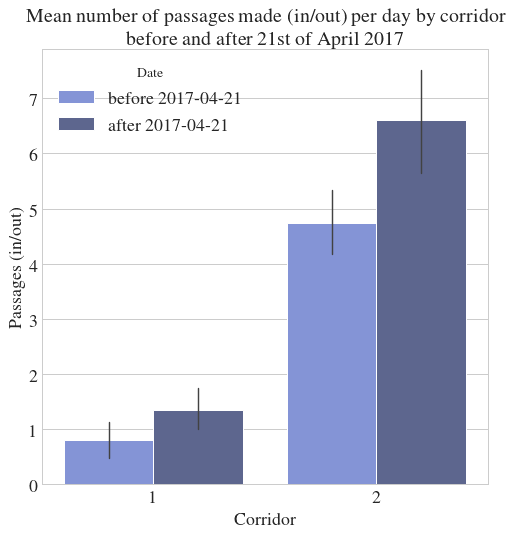

In [434]:
fig, ax = plt.subplots(1, figsize=(8,8))
cp = sns.dark_palette((260, 75, 60), input="husl")
sns.barplot(x='corridor',
            y='passage', 
            hue='Date',
            data=to_plot,
            palette=[cp[-1], cp[-3]],
            ax=ax)
ax.set_title('Mean number of passages made (in/out) per day by corridor \n before and after 21st of April 2017', fontsize=20)
ax.set_xlabel('Corridor', fontsize=18)
ax.set_ylabel('Passages (in/out)', fontsize=18)
labels = ax.xaxis.get_majorticklabels() 
ax.set_xticklabels(labels, rotation=0, ha='center', minor=False, fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18, title='Date')

In [340]:
out_pass = df_drop[df_drop.direction == 'out']
in_pass = df_drop[df_drop.direction == 'in']

In [341]:
out_pass = out_pass.groupby(['date', 'hour']).sum().reset_index()\
[['date', 'hour', 'passage']]

in_pass = in_pass.groupby(['date', 'hour']).sum().reset_index()\
[['date', 'hour', 'passage']]

In [342]:
out_pass = add_missing_hours(out_pass)
in_pass = add_missing_hours(in_pass)

In [343]:
out_pass.dtypes

date       datetime64[ns]
hour                int64
passage             int64
dtype: object

## Out passage 18.00-20.59 vs rest

In [344]:
ttest_ind(
    out_pass[out_pass.hour.isin([18,19,20])]['passage'],
    out_pass[~out_pass.hour.isin([18,19,20])]['passage']
)

Ttest_indResult(statistic=10.526217061839146, pvalue=8.328104801848668e-26)

## In passage 10am vs rest

In [345]:
ttest_ind(
    in_pass[in_pass.hour.isin([10])]['passage'],
    in_pass[~in_pass.hour.isin([10])]['passage']
)

Ttest_indResult(statistic=3.778572155557375, pvalue=0.00015844181900133146)

## In passage 5pm vs rest

In [346]:
ttest_ind(
    in_pass[in_pass.hour.isin([17])]['passage'],
    in_pass[~in_pass.hour.isin([17])]['passage']
)

Ttest_indResult(statistic=2.853520389591408, pvalue=0.004330678569078914)

## true passages mean 6pm vs rest

In [347]:
ttest_ind(
    hour_true_df[hour_true_df.hour == 18]['passage'],
    hour_true_df[hour_true_df.hour != 18]['passage']
)

Ttest_indResult(statistic=6.19985285731425, pvalue=5.782268700120123e-10)

## true per month 'January', 'February', 'July' vs rest

In [348]:
my_months = ['January', 'February', 'July']

In [349]:
ttest_ind(
    month_sum_true[month_sum_true.proper_month.isin(my_months)]['passage'],
    month_sum_true[~month_sum_true.proper_month.isin(my_months)]['passage']
)

Ttest_indResult(statistic=6.312182107857465, pvalue=3.997359835356852e-10)

### september vs rest

In [350]:
ttest_ind(
    month_sum_true[month_sum_true.proper_month == 'September']['passage'],
    month_sum_true[month_sum_true.proper_month != 'September']['passage']
)

Ttest_indResult(statistic=-4.335398936017515, pvalue=1.5897153683216747e-05)

### Mean passages

In [351]:
ms_true_copy = month_sum_true.copy()
month_sum_true = add_missing_dates(month_sum_true[['date', 'passage']])

In [352]:
month_sum_true[month_sum_true.proper_month == 'January']['passage'].mean()

9.956989247311828

In [353]:
month_sum_true[month_sum_true.proper_month == 'February']['passage'].mean()

10.552941176470588

In [354]:
month_sum_true[month_sum_true.proper_month == 'July']['passage'].mean()

10.96774193548387

In [355]:
month_sum_true[month_sum_true.proper_month == 'September']['passage'].mean()

2.9

### July 2017 vs rest

In [356]:
ttest_ind(
    month_sum_true[(month_sum_true.year == '2017') & (month_sum_true.proper_month == 'July')]['passage'],
    month_sum_true[(month_sum_true.year.isin(['2015', '2016'])) & (month_sum_true.proper_month == 'July')]['passage']
)

Ttest_indResult(statistic=-3.2751925522445986, pvalue=0.0014945853783479817)